# *RAFSwap*

## **1. Imports**

#### **0. Drive Mount**

In [1]:
import sys
import os

def detect_environment():
    """
    Detect if the code is running in Google Colab or locally, and perform environment-specific actions.

    Returns:
        str: The environment ('colab' or 'local').
    """
    if 'google.colab' in sys.modules:
        print('Running in Google Colab...')
        try:
            from google.colab import drive
            drive.mount('/content/drive')
            print("Colab-specific commands executed successfully.")
        except Exception as e:
            print(f"Error mounting Google Drive: {e}")
        print(f"Current working directory: {os.getcwd()}")
        return 'colab'
    else:
        print('Not running in Google Colab...')
        print(f"Current working directory: {os.getcwd()}")
        return 'local'

# Determine the environment
environment = detect_environment()
print(f"Environment detected: {environment}")

Running in Google Colab...
Mounted at /content/drive
Colab-specific commands executed successfully.
Current working directory: /content
Environment detected: colab


#### **1. StyleGAN2**

In [2]:
!apt-get update
!apt-get install -y ninja-build build-essential gcc g++ python3-dev libopenblas-dev libomp-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,566 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [3,614 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Pac

In [3]:
%cd /content

# Clone the StyleGAN2-ADA PyTorch repository
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git

# Navigate to the repository
%cd stylegan2-ada-pytorch

# Ensure the checkpoints directory exists and copy the pretrained model
!mkdir -p checkpoints
!cp "/content/drive/MyDrive/aml/stylegan2-ffhq-256x256.pkl" ./checkpoints/
!ls ./checkpoints/

# Copy the 'RAFSwap' folder into the 'models' folder
!cp -r '/content/drive/My Drive/RAFSwap/' '/content'

# List the content of '/content/RAFSwap/' to confirm
!ls -R /content/RAFSwap/

# Add the StyleGAN2-ADA PyTorch repo to the Python path to access `dnnlib`
import sys
sys.path.append('/content/stylegan2-ada-pytorch')

/content
Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 131 (delta 0), reused 0 (delta 0), pack-reused 129 (from 2)
Receiving objects: 100% (131/131), 1.13 MiB | 13.31 MiB/s, done.
Resolving deltas: 100% (57/57), done.
/content/stylegan2-ada-pytorch
stylegan2-ffhq-256x256.pkl
/content/RAFSwap/:
configs  criteria  models  pretrained_models

/content/RAFSwap/configs:
paths_config.py

/content/RAFSwap/criteria:
id_loss.py  lpips

/content/RAFSwap/criteria/lpips:
__init__.py  lpips.py  networks.py  utils.py

/content/RAFSwap/models:
encoders  stylegan2

/content/RAFSwap/models/encoders:
helpers.py  model_irse.py

/content/RAFSwap/models/stylegan2:
__init__.py  model.py  op

/content/RAFSwap/models/stylegan2/op:
conv2d_gradfix.py  fused_bias_act.cpp	     __init__.py    upfirdn2d_kernel.cu
fused_act.py	   fused_bias_act_kernel.cu  upfirdn2d.cpp  upfirdn2d.

In [4]:
import shutil

# Replace 'folder_path' with the path to the folder you want to delete
folder_path = '/content/RAFSwap'
#folder_path = '/content/stylegan2-ada-pytorch'

# Delete the folder and its contents
delete = False
if delete:
  shutil.rmtree(folder_path)
  print(f"Deleted folder: {folder_path}")

#### **2. Bisenet Import**

In [5]:
# Set the checkpoint path
bisenet_checkpoint_path = '/content/drive/MyDrive/aml/79999_iter.pth'

# Verify the file exists
if os.path.exists(bisenet_checkpoint_path):
    print("Checkpoint found:", bisenet_checkpoint_path)
else:
    print("Checkpoint not found. Please check the path.")

Checkpoint found: /content/drive/MyDrive/aml/79999_iter.pth


In [6]:
%cd /content

# Clone the repository
!git clone https://github.com/zllrunning/face-parsing.PyTorch.git

# Navigate into the repository
%cd /content/face-parsing.PyTorch

# Create the checkpoints directory if it doesn't exist
!mkdir -p checkpoints

# Verify the checkpoint exists and copy it to the checkpoints directory
checkpoint_path = '/content/drive/MyDrive/aml/79999_iter.pth'
!cp "$checkpoint_path" ./checkpoints/

# List files in the checkpoints directory to confirm
!ls ./checkpoints

/content
Cloning into 'face-parsing.PyTorch'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 92 (delta 21), reused 17 (delta 17), pack-reused 63 (from 1)
Receiving objects: 100% (92/92), 3.06 MiB | 28.51 MiB/s, done.
Resolving deltas: 100% (23/23), done.
/content/face-parsing.PyTorch
79999_iter.pth


#### **3. Essential Imports**

In [7]:
# Essential imports
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

# Torch and torchvision imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50
from torchvision.transforms.functional import to_pil_image

# Import the BiSeNet model from the cloned repository
from model import BiSeNet

seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

## **2. Dataloader**

In [8]:
import dlib

# Path to the landmarks predictor in Google Drive
landmarks_path = "/content/drive/MyDrive/shape_predictor_68_face_landmarks.dat"

# Initialize dlib's face detector (HOG-based) and the facial landmarks predictor
detector = dlib.get_frontal_face_detector()  # Face detector
predictor = dlib.shape_predictor(landmarks_path)  # Facial landmarks predictor

def align_face(image, predictor, detector, output_size=256, zoom_factor=1.15):
    """
    Align a face image based on facial landmarks with an adjustable zoom factor.

    Parameters:
        image_tensor (torch.Tensor): Input image tensor (C, H, W) in range [-1, 1].
        predictor (dlib.shape_predictor): Pretrained landmark predictor.
        detector (dlib.fhog_object_detector): dlib face detector.
        output_size (int): The desired size of the aligned output image.
        zoom_factor (float): Factor to zoom in on the face (default is 1.2).

    Returns:
        np.array: Aligned face image as a NumPy array.
    """
    # Denormalize and convert to OpenCV format
    image = image

    # Detect faces
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    if len(faces) == 0:
        return image

    # Process the first detected face
    face = faces[0]
    landmarks = predictor(gray, face)

    # Extract eye centers
    left_eye = np.array([landmarks.part(36).x, landmarks.part(36).y])  # Left eye corner
    right_eye = np.array([landmarks.part(45).x, landmarks.part(45).y])  # Right eye corner
    eye_midpoint = ((left_eye + right_eye) / 2).astype(np.float32)

    # Desired eye positions
    desired_left_eye = (output_size * 0.35, output_size * 0.35)
    desired_right_eye = (output_size * 0.65, output_size * 0.35)
    desired_distance = desired_right_eye[0] - desired_left_eye[0]

    # Scale factor with zoom
    current_distance = np.linalg.norm(right_eye - left_eye)
    scale = (desired_distance / current_distance) * zoom_factor

    # Compute rotation angle
    angle = np.degrees(np.arctan2(right_eye[1] - left_eye[1], right_eye[0] - left_eye[0]))

    # Compute affine transformation matrix
    center = tuple(eye_midpoint)
    M = cv2.getRotationMatrix2D(center, angle, scale)

    # Shift to center the aligned face
    tx = output_size / 2 - center[0]
    ty = output_size / 2 - center[1]
    M[:, 2] += (tx, ty)

    # Apply affine transformation
    aligned_face = cv2.warpAffine(image, M, (output_size, output_size), flags=cv2.INTER_CUBIC)

    # Convert back to RGB for visualization
    aligned_face_rgb = cv2.cvtColor(aligned_face, cv2.COLOR_BGR2RGB)
    return aligned_face_rgb

In [9]:
class RAFSwapDataset(Dataset):
    def __init__(self, base_dir, transform=None, max_pairs=100, same_identity_mode=False,
                 specify_folders=False, source_folder=None, target_folders=None):
        """
        Dataset for loading source and target images for RAFSwap.

        Parameters:
            base_dir (str): Base directory containing subfolders for each person.
            transform (callable, optional): Transformation to apply to images.
            max_pairs (int, optional): Maximum number of pairs per epoch. Default is 100.
            same_identity_mode (bool, optional): If True, ensures source and target images are the same.
            specify_folders (bool, optional): If True, allows specifying source and multiple target folders.
            source_folder (str, optional): Path to the folder for source images.
            target_folders (list, optional): List of paths to folders for target images.
        """
        self.base_dir = base_dir
        self.transform = transform
        self.max_pairs = max_pairs
        self.same_identity_mode = same_identity_mode  # Mode flag
        self.specify_folders = specify_folders
        self.source_folder = source_folder
        self.target_folders = target_folders if target_folders else []

        if self.specify_folders:
            # Check if source folder and at least one target folder are provided
            if not self.source_folder or not self.target_folders:
                raise ValueError("Source folder and at least one target folder must be provided when specify_folders is True.")

            # Collect all images in the specified source folder
            self.source_images = sorted(glob.glob(os.path.join(self.source_folder, "*.jpg")))
            if not self.source_images:
                raise ValueError("No images found in the specified source folder!")

            # Collect all images from the specified target folders
            self.target_images = []
            for folder in self.target_folders:
                images = sorted(glob.glob(os.path.join(folder, "*.jpg")))
                if not images:
                    raise ValueError(f"No images found in target folder: {folder}")
                self.target_images.extend(images)
        else:
            # Collect all subfolders in the base directory
            self.folders = [f.path for f in os.scandir(base_dir) if f.is_dir()]
            if not self.folders:
                raise ValueError("No subfolders found in the base directory!")

    def __len__(self):
        return self.max_pairs

    def __getitem__(self, idx):
        if self.specify_folders:
            # Randomly select a source image
            source_image_path = np.random.choice(self.source_images)

            # Randomly select a target image from the target folders
            if self.same_identity_mode:
                target_image_path = source_image_path
            else:
                target_image_path = np.random.choice(self.target_images)

            source_image = cv2.imread(source_image_path)
            target_image = cv2.imread(target_image_path)
        else:
            # Randomly select folders and images
            source_folder = np.random.choice(self.folders)
            target_folder = source_folder
            while target_folder == source_folder:
                target_folder = np.random.choice(self.folders)

            # Select images from folders
            source_image = self._load_random_image(source_folder)
            target_image = source_image if self.same_identity_mode else self._load_random_image(target_folder)

        # Align faces
        source_image = align_face(source_image, predictor, detector)
        target_image = align_face(target_image, predictor, detector)

        # Apply transformations
        if self.transform:
            source_image = self.transform(source_image)
            target_image = self.transform(target_image)

        return source_image, target_image

    def _load_random_image(self, folder):
        """Helper to load a random image from a folder."""
        images = sorted(glob.glob(os.path.join(folder, "*.jpg")))
        if not images:
            raise ValueError(f"No images found in folder: {folder}")
        image_path = np.random.choice(images)
        image = cv2.imread(image_path)
        return image


# Example Usage

# Transformations (optimized for RAFSwap)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),  # Ensure input size matches StyleGAN2
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # StyleGAN normalization
])

# Dataset and DataLoader for RAFSwap with specified folders
source_folder = "/content/drive/MyDrive/VGGFace2_small/n000012"
target_folders = [
    "/content/drive/MyDrive/VGGFace2_small/n000008",
    "/content/drive/MyDrive/VGGFace2_small/n000029",
    "/content/drive/MyDrive/VGGFace2_small/n000052"
]
rafswap_dataset = RAFSwapDataset(
    base_dir="/content/drive/My Drive/VGGFace2_small",
    transform=transform,
    max_pairs=100,
    same_identity_mode=False,
    specify_folders=True,
    source_folder=source_folder,
    target_folders=target_folders
)

# Optimized DataLoader
dataloader = DataLoader(
    rafswap_dataset,
    batch_size=20,  # Adjust batch size based on GPU memory
    shuffle=True,
    num_workers=0,  # Enable parallel data loading
    pin_memory=True  # Speed up data transfer to GPU
)

In [10]:
# Function to denormalize images
def denormalize_image(image_tensor, mean, std):
    """
    Denormalize an image tensor using the provided mean and std.

    Parameters:
        image_tensor (torch.Tensor): Normalized image tensor.
        mean (list): Mean used for normalization.
        std (list): Std deviation used for normalization.

    Returns:
        np.array: Denormalized image ready for visualization.
    """
    mean = np.array(mean)
    std = np.array(std)
    image = image_tensor.permute(1, 2, 0).numpy()  # Change to HWC for visualization
    image = image * std + mean  # Denormalize
    return image.clip(0, 1)  # Clip to [0, 1]

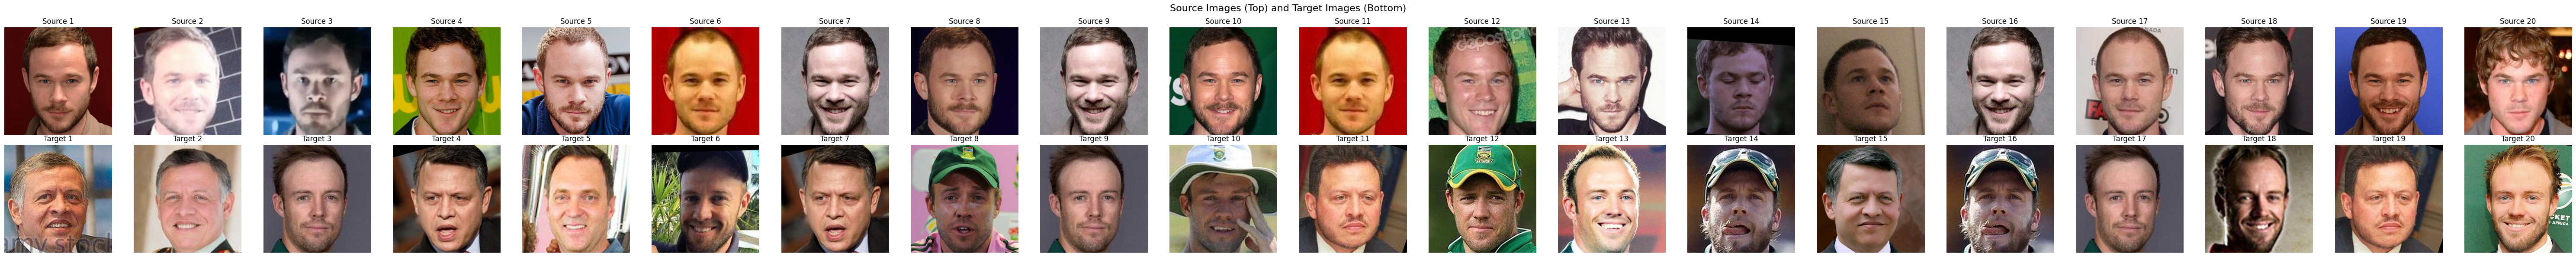

In [11]:
# Visualizing a full batch
for source_batch, target_batch in dataloader:
    batch_size = source_batch.size(0)

    # Create a grid to display the full batch
    fig, axes = plt.subplots(2, batch_size, figsize=(batch_size * 3, 6))
    fig.suptitle("Source Images (Top) and Target Images (Bottom)", fontsize=16)

    for i in range(batch_size):
        # Denormalize source and target images
        source_image = denormalize_image(source_batch[i], mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        target_image = denormalize_image(target_batch[i], mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

        # Display the source image
        axes[0, i].imshow(source_image)
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Source {i + 1}")

        # Display the target image
        axes[1, i].imshow(target_image)
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Target {i + 1}")

    plt.tight_layout()
    plt.show()
    break  # Show one batch only

## **3. RAFSwap**

#### **1. Hierarchical Encoder**

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50
from torchvision.models import ResNet50_Weights

class HierarchicalEncoder(nn.Module):
    def __init__(self):
        """
        Hierarchical Encoder built on ResNet50 backbone with 512-channel mappings for all outputs.
        """
        super(HierarchicalEncoder, self).__init__()

        # Load ResNet50 backbone
        self.resnet = resnet50(weights=ResNet50_Weights.DEFAULT)

        # Extract ResNet components for hierarchical features
        self.conv1 = self.resnet.conv1
        self.bn1 = self.resnet.bn1
        self.relu = self.resnet.relu
        self.maxpool = self.resnet.maxpool
        self.layer1 = self.resnet.layer1  # Early features
        self.layer2 = self.resnet.layer2  # Middle features
        self.layer3 = self.resnet.layer3  # Late features

        # Map feature channels to 512 for all scales
        self.latlayer1 = nn.Conv2d(256, 512, kernel_size=1, stride=1, padding=0)  # For c1
        self.latlayer2 = nn.Conv2d(512, 512, kernel_size=1, stride=1, padding=0)  # For c2
        self.latlayer3 = nn.Conv2d(1024, 512, kernel_size=1, stride=1, padding=0)  # For c3

    def forward(self, x):
        """
        Forward pass for the hierarchical encoder.

        Parameters:
            x (torch.Tensor): Input image tensor of shape (B, 3, H, W).

        Returns:
            tuple(torch.Tensor, torch.Tensor, torch.Tensor): Hierarchical features c1, c2, and c3,
            each mapped to 512 channels and corresponding to different scales.
        """
        # Initial ResNet layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Extract hierarchical features
        c1 = self.layer1(x)  # Early features (B, 256, H/4, W/4)
        c2 = self.layer2(c1)  # Middle features (B, 512, H/8, W/8)
        c3 = self.layer3(c2)  # Late features (B, 1024, H/16, W/16)

        # Map all features to 512 channels
        c1 = self.latlayer1(c1)
        c2 = self.latlayer2(c2)
        c3 = self.latlayer3(c3)

        return c1, c2, c3  # Return hierarchical features

In [13]:
# Ensure device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Move the encoder to the device
encoder = HierarchicalEncoder().to(device)

# Test the encoder with the dataloader
for source_images, target_images in dataloader:
    # Move images to the device
    source_images = source_images.to(device)
    target_images = target_images.to(device)

    # Use mixed precision context manager for GPU
    with torch.amp.autocast(device_type=device, enabled=(device == 'cuda')):
        # Get hierarchical features
        Fs = encoder(source_images)  # Source features
        Ft = encoder(target_images)  # Target features

    # Print dimensions for debugging
    print("Source Features:")
    for i, feature in enumerate(Fs, 1):
        print(f"  c{i} shape: {feature.shape}")

    print("Target Features:")
    for i, feature in enumerate(Ft, 1):
        print(f"  c{i} shape: {feature.shape}")

    break  # Test one batch only

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s]


Source Features:
  c1 shape: torch.Size([20, 512, 64, 64])
  c2 shape: torch.Size([20, 512, 32, 32])
  c3 shape: torch.Size([20, 512, 16, 16])
Target Features:
  c1 shape: torch.Size([20, 512, 64, 64])
  c2 shape: torch.Size([20, 512, 32, 32])
  c3 shape: torch.Size([20, 512, 16, 16])


#### **2. Segmentor**

In [14]:
class FaceSegmentor:
    def __init__(self, checkpoint_path, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        self.model = BiSeNet(n_classes=19)  # BiSeNet with 19 classes for face parsing
        self.model.to(self.device)
        self.model.load_state_dict(torch.load(checkpoint_path, map_location=self.device, weights_only=True))
        self.model.eval()

        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),  # Resize for BiSeNet
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Palette for visualization
        self.palette = np.array([
            [0, 0, 0],      # Class 0 (Background)
            [0, 0, 0],      # Class 1 (Face)
            [0, 0, 255],    # Class 2 (Eyebrow 1)
            [0, 0, 255],    # Class 3 (Eyebrow 2)
            [0, 255, 0],    # Class 4 (Eye 1)
            [0, 255, 0],    # Class 5 (Eye 2)
            [0, 0, 0],      # Class 6 (Unused)
            [0, 0, 0],      # Class 7
            [0, 0, 0],      # Class 8
            [0, 0, 0],      # Class 9 (Unused)
            [0, 255, 255],  # Class 10 (Nose)
            [0, 0, 0],      # Class 11 (Unused)
            [255, 0, 0],    # Class 12
            [255, 0, 0],    # Class 13 (under lip)
            [0, 0, 0],      # Class 14 (Throat)
            [0, 0, 0],      # Class 15 (Unused)
            [0, 0, 0],      # Class 16 (Shirt)
            [0, 0, 0],      # Class 17 (Hair)
        ])

    def generate_mask(self, image):
        """
        Generates a face segmentation mask for the given image.

        Parameters:
            image (PIL.Image or numpy.ndarray): Input image.

        Returns:
            numpy.ndarray: Generated mask of shape (512, 512).
        """
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)

        input_tensor = self.transform(image).unsqueeze(0).to(self.device)
        with torch.no_grad():
            output = self.model(input_tensor)[0]
        parsing = output.squeeze(0).cpu().numpy().argmax(0)
        return parsing

    def generate_binary_masks(self, mask, original_shape=None):
        """
        Generates binary masks for eyes, eyebrows, nose, and mouth.

        Parameters:
            mask (numpy.ndarray): Segmentation mask from the model (512x512).
            original_shape (tuple): Ignored as we now keep the mask at 512x512.

        Returns:
            dict: Dictionary of binary masks as PyTorch tensors (all are 512x512).
        """
        class_groups = {
            'eyes': [4, 5],       # Eyes
            'eyebrows': [2, 3],   # Eyebrows
            'nose': [10],         # Nose
            'mouth': [12, 13],    # Mouth
        }

        binary_masks = {}
        for feature, class_ids in class_groups.items():
            binary_mask = np.isin(mask, class_ids).astype(np.uint8)
            binary_masks[feature] = torch.tensor(binary_mask, dtype=torch.float32).unsqueeze(0).to(self.device)

        return binary_masks

    def forward(self, images):
        """
        Takes a batch of images, generates segmentation masks, and binary masks.

        Parameters:
            images (torch.Tensor): Batch of images of shape (B, C, H, W).

        Returns:
            dict: Dictionary of binary masks for each region (e.g., eyes, eyebrows, etc.).
                  Each mask is a tensor with shape (B, 1, 512, 512).
        """
        batch_size = images.size(0)
        all_binary_masks = {region: [] for region in ['eyes', 'eyebrows', 'nose', 'mouth']}

        for i in range(batch_size):
            image_array = images[i].permute(1, 2, 0).cpu().numpy()  # Convert to HWC format
            image_array = (image_array * 255).astype(np.uint8)      # Convert to uint8
            mask = self.generate_mask(image_array)                 # Generate segmentation mask
            binary_masks = self.generate_binary_masks(mask)        # Generate binary masks

            for region, binary_mask in binary_masks.items():
                all_binary_masks[region].append(binary_mask)

        for region in all_binary_masks.keys():
            all_binary_masks[region] = torch.stack(all_binary_masks[region])  # Shape: (B, 1, 512, 512)

        return all_binary_masks


    def visualize_masks(self, image):
        """
        Visualize segmentation masks overlaid on the original image.

        Parameters:
            image (numpy.ndarray): Original RGB image (H x W x C).

        Returns:
            None: Displays the visualizations.
        """
        # Generate the segmentation mask
        segmentation_mask = self.generate_mask(image)

        # Resize the segmentation mask to match the image dimensions
        resized_mask = cv2.resize(segmentation_mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

        # Define colors for each region
        colors = {
            2: [0, 0, 255],    # Eyebrows (Class IDs 2, 3)
            3: [0, 0, 255],
            4: [0, 255, 0],    # Eyes (Class IDs 4, 5)
            5: [0, 255, 0],
            10: [255, 255, 0], # Nose (Class ID 10)
            12: [255, 0, 0],   # Mouth (Class IDs 12, 13)
            13: [255, 0, 0],
        }

        # Create an overlay image
        overlay = image.copy()

        # Overlay each region with its corresponding color
        for class_id, color in colors.items():
            overlay[resized_mask == class_id] = color

        # Plot the original image and the overlay
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(overlay)
        plt.title("Segmented Image with Masks")
        plt.axis("off")

        plt.show()


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 191MB/s]


Binary Mask Shapes:
  eyes: torch.Size([20, 1, 512, 512])
  eyebrows: torch.Size([20, 1, 512, 512])
  nose: torch.Size([20, 1, 512, 512])
  mouth: torch.Size([20, 1, 512, 512])


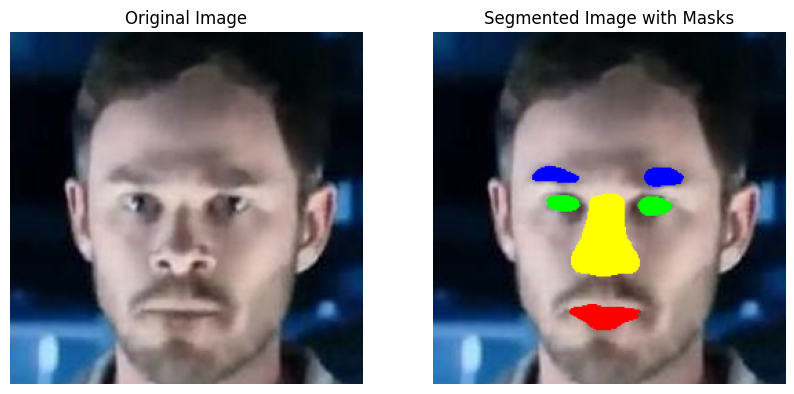

In [15]:
# Import the BiSeNet model from the cloned repository
from model import BiSeNet

# Initialize FaceSegmentor
segmentor = FaceSegmentor(checkpoint_path='/content/face-parsing.PyTorch/checkpoints/79999_iter.pth', device=device)

# Process a batch of images
for source_images, target_images in dataloader:
    source_images = source_images.to(device)

    # Pass the batch through the segmentor
    binary_masks = segmentor.forward(source_images)  # Get binary masks for the batch

    # Print the shapes of the tensors for verification
    print("Binary Mask Shapes:")
    for region, masks in binary_masks.items():
        print(f"  {region}: {masks.shape}")  # Should be (B, 1, 512, 512)

    # Visualize the first image and its masks
    first_image = source_images[0].permute(1, 2, 0).cpu().numpy()  # Convert to HWC
    first_image = ((first_image * 0.5) + 0.5) * 255  # Denormalize
    first_image = first_image.astype(np.uint8)

    first_binary_masks = {region: masks[0].unsqueeze(0) for region, masks in binary_masks.items()}
    segmentor.visualize_masks(first_image)

    break  # Only process the first batch

#### **3. Global Source Feature-Adaptive Branch**

In [16]:
class GAPMLPBranch(nn.Module):
    def __init__(self, input_channels, hidden_dim=512, output_dim=512):
        """
        Global Source Feature-Adaptive (SFA) Branch with Global Average Pooling (GAP) and MLP.

        Parameters:
            input_channels (int): Number of channels in the smallest feature map (e.g., 1024).
            hidden_dim (int, optional): Number of neurons in the hidden layer of the MLP. Default is 512.
            output_dim (int, optional): Number of output dimensions after the MLP. Default is 512.
        """
        super(GAPMLPBranch, self).__init__()
        self.gap = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling to (1, 1)
        self.mlp = nn.Sequential(
            nn.Linear(input_channels, hidden_dim),  # Fully connected layer
            nn.ReLU(inplace=True),                 # Activation
            nn.Linear(hidden_dim, output_dim)      # Fully connected layer
        )

    def forward(self, x):
        """
        Forward pass of the GAP + MLP branch.

        Parameters:
            x (torch.Tensor): Input tensor of shape (B, C, H, W), where B is batch size, C is number of channels.

        Returns:
            torch.Tensor: Output tensor of shape (B, output_dim).
        """
        with torch.amp.autocast(device_type='cuda', enabled=(x.device.type == 'cuda')):  # Use mixed precision on GPU
            x = self.gap(x)           # GAP reduces spatial dimensions to (B, C, 1, 1)
            x = x.view(x.size(0), -1)  # Flatten to (B, C)
            x = self.mlp(x)            # Pass through the MLP
        return x

In [17]:
# Ensure the device is properly set
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize GAP + MLP branch
gap_mlp = GAPMLPBranch(input_channels=512).to(device)  # Assuming input from c3 has 512 channels

# Move the encoder to the same device as the images
encoder = encoder.to(device)

# Example loop to test the encoder with DataLoader
for source_images, _ in dataloader:  # Assuming DataLoader provides (source_images, target_images)
    # Move images to GPU if available
    source_images = source_images.to(device)

    with torch.amp.autocast(device_type='cuda', enabled=(device == 'cuda')):  # Enable mixed precision on GPU
        # Pass images through encoder to get hierarchical features
        c1, c2, c3 = encoder(source_images)  # Outputs: c1 (B, 256, H1, W1), c2 (B, 512, H2, W2), c3 (B, 1024, H3, W3)

        # Pass c3 through GAP + MLP branch
        global_features = gap_mlp(c3)  # Output: (B, 512)

    print("Source Image Shape:", source_images.shape)
    print("c3 Shape:", c3.shape)
    print("Global Features Shape:", global_features.shape)

    # Break after one batch for demonstration
    break

Source Image Shape: torch.Size([20, 3, 256, 256])
c3 Shape: torch.Size([20, 512, 16, 16])
Global Features Shape: torch.Size([20, 512])


#### **4. RegionAwareTransformer RAT**

In [18]:
class RegionAwareTransformer(nn.Module):
    def __init__(self, embedding_dim=512, device='cuda' if torch.cuda.is_available() else 'cpu'):
        super(RegionAwareTransformer, self).__init__()
        self.embedding_dim = embedding_dim
        self.device = device
        self.linear = nn.Linear(embedding_dim, embedding_dim).to(self.device)

    def resize_masks(self, binary_masks, feature_shape):
        """
        Resizes binary masks to match the resolution of the given feature map.

        Parameters:
            binary_masks (dict): Dictionary of binary masks for each region (e.g., eyes, nose).
                Each mask is a tensor with shape (B, 1, 512, 512).
            feature_shape (tuple): Target resolution (H, W) for the feature map.

        Returns:
            list: List of resized binary masks for each region (all are B x 1 x H x W).
        """
        resized_masks = []
        for region, mask in binary_masks.items():
            mask = mask.to(self.device)  # Ensure mask is on the correct device
            resized = F.interpolate(
                mask,
                size=feature_shape,
                mode='nearest'  # Maintain binary nature of masks
            )
            resized_masks.append(resized)
        return resized_masks  # List of tensors [B x 1 x H x W] for each region

    def generate_tokens(self, features, binary_masks, feature_shape):
        """
        Compute region-aware tokens from features and multiple binary masks.

        Parameters:
            features (torch.Tensor): Feature map of shape (B, C, H, W).
            binary_masks (dict): Binary masks for regions, each of shape (B, 1, 512, 512).
            feature_shape (tuple): Target resolution (H, W) for the feature map.

        Returns:
            torch.Tensor: Tokens of shape (B, L, 512), where L is the number of regions.
        """
        batch_size, _, height, width = features.shape
        assert feature_shape == (height, width), "Feature shape and resolution mismatch."

        # Resize masks to match the feature map resolution
        resized_masks = self.resize_masks(binary_masks, feature_shape)  # List of B x 1 x H x W masks
        tokens = []

        for mask in resized_masks:  # Process each resized mask
            # Element-wise multiplication and mean pooling
            masked_features = features * mask  # B x C x H x W
            region_sum = masked_features.view(batch_size, -1, height * width).sum(dim=2)  # B x C
            region_count = mask.view(batch_size, -1).sum(dim=1).clamp(min=1)  # B
            region_mean = region_sum / region_count.unsqueeze(1)  # B x C

            # Linear transformation to generate a token
            token = self.linear(region_mean)  # B x embedding_dim
            tokens.append(token)

        # Stack tokens for all regions
        tokens = torch.stack(tokens, dim=1)  # Shape: B x L x embedding_dim
        return tokens

    def reshape_tokens(self, tokens):
        """
        Reshape tokens from (B, L, D) to (B*L, D).

        Parameters:
            tokens (torch.Tensor): Input tokens of shape (B, L, D).

        Returns:
            torch.Tensor: Reshaped tokens of shape (B*L, D).
        """
        batch_size, num_tokens, embedding_dim = tokens.shape
        reshaped_tokens = tokens.view(-1, embedding_dim)  # Reshape to (B*L, D)
        return reshaped_tokens

In [19]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        """
        Multi-Head Self-Attention mechanism.

        Parameters:
            embed_dim (int): Dimension of input and output embeddings (D).
            num_heads (int): Number of attention heads (H).
        """
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"

        # Query, Key, and Value projection layers
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)

        # Output projection layer
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        """
        Forward pass for MSA.

        Parameters:
            x (torch.Tensor): Input tokens of shape (B*L, D).

        Returns:
            torch.Tensor: Output tokens of shape (B*L, D).
        """
        batch_size_l, embed_dim = x.shape  # B*L, D
        assert embed_dim == self.embed_dim, f"Expected embedding dim {self.embed_dim}, but got {embed_dim}"

        # Split the input into multiple heads
        Q = self.q_proj(x).view(batch_size_l, self.num_heads, self.head_dim).transpose(0, 1)  # (H, B*L, D/H)
        K = self.k_proj(x).view(batch_size_l, self.num_heads, self.head_dim).transpose(0, 1)  # (H, B*L, D/H)
        V = self.v_proj(x).view(batch_size_l, self.num_heads, self.head_dim).transpose(0, 1)  # (H, B*L, D/H)

        # Scaled Dot-Product Attention
        attn_weights = F.softmax(torch.bmm(Q, K.transpose(1, 2)) / self.head_dim**0.5, dim=-1)  # (H, B*L, B*L)
        attn_output = torch.bmm(attn_weights, V)  # Shape: (H, B*L, D/H)

        # Concatenate attention output from all heads
        attn_output = attn_output.transpose(0, 1).contiguous().view(batch_size_l, self.embed_dim)  # Shape: (B*L, D)

        # Apply output projection
        output = self.out_proj(attn_output)  # Shape: (B*L, D)

        return output

In [20]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        """
        Feed-Forward Network with two linear layers and ReLU activation.

        Parameters:
            embed_dim (int): Dimension of input and output embeddings (D).
            hidden_dim (int): Dimension of the intermediate hidden layer.
        """
        super(FeedForwardNetwork, self).__init__()
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.activation = nn.ReLU()

    def forward(self, x):
        """
        Forward pass for FFN.

        Parameters:
            x (torch.Tensor): Input tokens of shape (B*L, D).

        Returns:
            torch.Tensor: Output tokens of shape (B*L, D).
        """
        x = self.fc1(x)  # First linear transformation: (B*L, D) -> (B*L, hidden_dim)
        x = self.activation(x)  # Apply ReLU
        x = self.fc2(x)  # Second linear transformation: (B*L, hidden_dim) -> (B*L, D)
        return x


In [21]:
class TransformerLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim):
        """
        A Transformer layer that combines MSA, FFN, LN, and RC.

        Parameters:
            embed_dim (int): Dimension of input and output embeddings (D).
            num_heads (int): Number of attention heads for MSA.
            hidden_dim (int): Dimension of the intermediate hidden layer in FFN.
        """
        super(TransformerLayer, self).__init__()
        self.ln1 = nn.LayerNorm(embed_dim)  # LayerNorm before MSA
        self.msa = MultiHeadSelfAttention(embed_dim, num_heads)  # Multi-Head Self-Attention
        self.ln2 = nn.LayerNorm(embed_dim)  # LayerNorm before FFN
        self.ffn = FeedForwardNetwork(embed_dim, hidden_dim)  # Feed-Forward Network

    def forward(self, x):
        """
        Forward pass for the Transformer layer.

        Parameters:
            x (torch.Tensor): Input tokens of shape (B*L, D).

        Returns:
            torch.Tensor: Refined tokens of shape (B*L, D).
        """
        # MSA with Residual Connection
        x = x + self.msa(self.ln1(x))  # LN -> MSA -> Add Residual

        # FFN with Residual Connection
        x = x + self.ffn(self.ln2(x))  # LN -> FFN -> Add Residual

        return x

In [22]:
class TransformerStack(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim, num_layers):
        """
        Stack of Transformer layers.

        Parameters:
            embed_dim (int): Dimension of input and output embeddings (D).
            num_heads (int): Number of attention heads for MSA.
            hidden_dim (int): Dimension of the intermediate hidden layer in FFN.
            num_layers (int): Number of Transformer layers to stack.
        """
        super(TransformerStack, self).__init__()
        self.layers = nn.ModuleList([
            TransformerLayer(embed_dim, num_heads, hidden_dim) for _ in range(num_layers)
        ])

    def forward(self, x):
        """
        Forward pass for the Transformer stack.

        Parameters:
            x (torch.Tensor): Input tokens of shape (B*L, D).

        Returns:
            torch.Tensor: Refined tokens of shape (B*L, D).
        """
        for layer in self.layers:
            x = layer(x)  # Pass through each Transformer layer
        return x

#### **5. RegionAwareProjector RAP**

In [23]:
class RegionAwareProjector(nn.Module):
    def __init__(self, embed_dim=512):
        """
        Region-Aware Projector (RAP) for local identity-augmented features.

        Parameters:
            embed_dim (int): Dimension of the embedding (default: 512).
        """
        super(RegionAwareProjector, self).__init__()
        self.embed_dim = embed_dim
        self.projection_weight = nn.Linear(embed_dim, embed_dim)  # Linear projection (W_P in Eq. (5))

    def combine_masks(self, resized_masks):
        """
        Combine resized masks into a single tensor.

        Parameters:
            resized_masks (list): List of binary masks (B, 1, H, W).

        Returns:
            torch.Tensor: Combined masks of shape (B, L, H, W).
        """
        return torch.cat(resized_masks, dim=1)  # Combine masks along the channel axis (L regions)

    def forward(self, F_t, resized_masks, T_s):
        """
        Forward pass of the Region-Aware Projector.

        Parameters:
            F_t (torch.Tensor): Target feature maps of shape (B, 512, H, W).
            resized_masks (list): List of resized binary masks (B, 1, H, W) for each region.
            T_s (torch.Tensor): Tokens from RAT, shape (B*L, 512).

        Returns:
            torch.Tensor: Local identity-augmented features (F_l) of shape (B, 512, H, W).
        """
        B, C, H, W = F_t.shape  # Feature map dimensions
        num_regions = len(resized_masks)  # Number of regions (L)

        # Combine masks into a single tensor
        M_t = self.combine_masks(resized_masks)  # Shape: (B, L, H, W)

        # Reshape tokens to (B, L, C) from (B*L, C)
        T_s = T_s.view(B, num_regions, self.embed_dim)  # Shape: (B, L, 512)

        # Flatten spatial dimensions of F_t and M_t
        F_t_flat = F_t.view(B, C, -1).permute(0, 2, 1)  # Shape: (B, HW, 512)
        M_t_flat = M_t.view(B, num_regions, -1).permute(0, 2, 1)  # Shape: (B, HW, L)

        # Compute attention scores
        attention_scores = F.softmax(M_t_flat, dim=2)  # Shape: (B, HW, L)

        # Compute weighted tokens
        attention_output = torch.bmm(attention_scores, T_s)  # Shape: (B, HW, 512)

        # Linear projection and reshape
        updated_features = self.projection_weight(attention_output)  # Shape: (B, HW, 512)
        updated_features = updated_features.permute(0, 2, 1).view(B, C, H, W)  # Shape: (B, 512, H, W)

        # Add back to original F_t to form F_l
        F_l = F_t + updated_features
        return F_l

#### **6. StyleVector Extractor**

In [24]:
class GradualStyleBlock(nn.Module):
    def __init__(self, in_c, out_c, spatial):
        super(GradualStyleBlock, self).__init__()
        self.out_c = out_c
        num_pools = int(torch.log2(torch.tensor(spatial)))
        modules = []
        modules.append(nn.Conv2d(in_c, out_c, kernel_size=3, stride=2, padding=1))
        modules.append(nn.LeakyReLU())
        for _ in range(num_pools - 1):
            modules.append(nn.Conv2d(out_c, out_c, kernel_size=3, stride=2, padding=1))
            modules.append(nn.LeakyReLU())
        self.convs = nn.Sequential(*modules)
        self.linear = nn.Linear(out_c, out_c)

    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.linear(x)
        return x

In [25]:
class StyleVectorExtractor(nn.Module):
    def __init__(self):
        super(StyleVectorExtractor, self).__init__()

        # Gradual Style Blocks for each scale
        self.style_block_c3_4x4 = GradualStyleBlock(512, 512, spatial=16)  # c3 -> 4x4 (1 vector)
        self.style_block_c3_8x8 = GradualStyleBlock(512, 512, spatial=16)  # c3 -> 8x8 (2 vectors)
        self.style_block_c3_16x16 = GradualStyleBlock(512, 512, spatial=16)  # c3 -> 16x16 (2 vectors)

        self.style_block_c2_32x32 = GradualStyleBlock(512, 512, spatial=32)  # c2 -> 32x32 (2 vectors)

        self.style_block_c1_64x64 = GradualStyleBlock(512, 512, spatial=64)  # c1 -> 64x64 (2 vectors)
        self.style_block_c1_128x128 = GradualStyleBlock(512, 512, spatial=64)  # c1 -> 128x128 (2 vectors)
        self.style_block_c1_256x256 = GradualStyleBlock(512, 512, spatial=64)  # c1 -> 256x256 (2 vectors)

    def forward(self, F_t):
        """
        Extract 14 style vectors from hierarchical feature map F_t.

        Parameters:
            F_t (dict): Dictionary containing hierarchical features c1, c2, c3.

        Returns:
            torch.Tensor: Style vectors of shape (B, 14, 512).
        """
        c1, c2, c3 = F_t['c1'], F_t['c2'], F_t['c3']

        # Style vectors from c3 (5 vectors total)
        style_4x4 = self.style_block_c3_4x4(c3)  # 4x4 (1 vector)
        style_8x8 = torch.stack([self.style_block_c3_8x8(c3) for _ in range(2)], dim=1)  # 8x8 (2 vectors)
        style_16x16 = torch.stack([self.style_block_c3_16x16(c3) for _ in range(2)], dim=1)  # 16x16 (2 vectors)

        # Style vectors from c2 (2 vectors total)
        style_32x32 = torch.stack([self.style_block_c2_32x32(c2) for _ in range(2)], dim=1)  # 32x32 (2 vectors)

        # Style vectors from c1 (6 vectors total)
        style_64x64 = torch.stack([self.style_block_c1_64x64(c1) for _ in range(2)], dim=1)  # 64x64 (2 vectors)
        style_128x128 = torch.stack([self.style_block_c1_128x128(c1) for _ in range(2)], dim=1)  # 128x128 (2 vectors)
        style_256x256 = torch.stack([self.style_block_c1_256x256(c1) for _ in range(2)], dim=1)  # 256x256 (2 vectors)

        # Combine all style vectors (13 in total)
        style_vectors = torch.cat([
            style_4x4.unsqueeze(1), style_8x8, style_16x16,
            style_32x32,
            style_64x64, style_128x128, style_256x256
        ], dim=1)  # Shape: (B, 13, 512)

        # Add the 14th style vector (duplicate the last vector for the ToRGB layer)
        style_vector_final = style_vectors[:, -1:, :]  # Extract last vector
        style_vectors = torch.cat([style_vectors, style_vector_final], dim=1)  # Shape: (B, 14, 512)

        return style_vectors

#### **7. Face Mask Predictor FMP**

In [26]:
class FaceMaskPredictor(nn.Module):
    def __init__(self, in_channels_list=[512, 512, 256, 128, 64], bottleneck_channels=32):
        """
        Face Mask Predictor using StyleGAN feature maps.

        Parameters:
            in_channels_list (list): Input channels for selected feature maps.
            bottleneck_channels (int): Reduced channels after bottleneck.
        """
        super(FaceMaskPredictor, self).__init__()
        self.bottlenecks = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_ch, bottleneck_channels, kernel_size=1),
                nn.LeakyReLU(),
                nn.Upsample(size=(256, 256), mode='bilinear', align_corners=False)
            ) for in_ch in in_channels_list
        ])
        self.conv_final = nn.Conv2d(bottleneck_channels * len(in_channels_list), 1, kernel_size=1)

    def forward(self, feature_maps):
        """
        Generate the soft mask.

        Parameters:
            feature_maps (list): List of feature maps (tensors).

        Returns:
            torch.Tensor: Soft mask of shape (B, 1, 256, 256).
        """
        # Ensure input tensors are float32
        feature_maps = [fm.to(torch.float32) for fm in feature_maps]

        upsampled_features = [bottleneck(fm) for fm, bottleneck in zip(feature_maps, self.bottlenecks)]
        combined_features = torch.cat(upsampled_features, dim=1)  # Concatenate along channels
        mask = torch.sigmoid(self.conv_final(combined_features))
        return mask

#### **8. StyleGAN2**

In [27]:
import dnnlib
import legacy

# Path to the pre-trained weights
weights_path = "/content/drive/My Drive/aml/stylegan2-ffhq-256x256.pkl"

# Load the pre-trained StyleGAN generator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
with dnnlib.util.open_url(weights_path) as f:
    checkpoint = legacy.load_network_pkl(f)  # Load the `.pkl` file
    gen = checkpoint['G_ema'].to(device)  # Extract and move the generator to GPU

Setting up PyTorch plugin "bias_act_plugin"... 

/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.


torch.Size([2, 3, 256, 256])


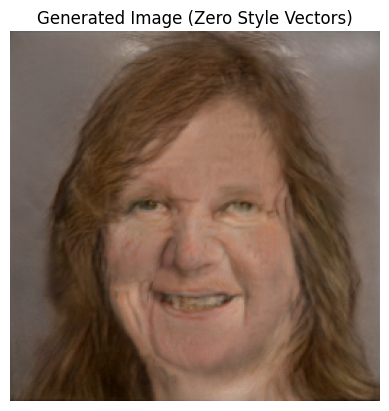

In [28]:
# Zero tensor generation and image visualization
def visualize_image(image_tensor, title="Generated Image"):
    """
    Visualize the generated image from StyleGAN2.
    """
    image = image_tensor[0].permute(1, 2, 0).cpu().numpy()
    image = (image + 1) / 2  # Normalize from [-1, 1] to [0, 1]
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()

# Create a batch of all-zero style vectors
batch_size = 2  # Single image generation
n_latents = gen.num_ws  # Number of latent vectors required for the generator
style_vectors = torch.zeros(batch_size, n_latents, 512, device=device)

# Generate the image
with torch.no_grad():  # Disable gradients for inference
    generated_image = gen.synthesis(style_vectors, noise_mode='const')  # Generate image

print(generated_image.size())
# Visualize the result
visualize_image(generated_image, "Generated Image (Zero Style Vectors)")

## **4. Forward Pass Function**

In [29]:
def process_and_visualize_images(dataloader, encoder, segmentor, rat, transformer_stack, rap, gap_mlp,
                                 style_vector_extractor, FMP, G, device, print_details=1, print_images=1):
    """
    Processes a batch of source and target images through the full pipeline.
    Prints details for the batch, and visualizes the results for the first image in the batch.

    Parameters:
        print_details (int): If 1, prints detailed information for the batch. If 0, only visualizes the first image.
    """
    feature_shapes = {
        'c1': (64, 64),
        'c2': (32, 32),
        'c3': (16, 16)
    }

    for source_images, target_images in dataloader:
        # Move images to device
        source_images = source_images.to(device)
        target_images = target_images.to(device)

        if print_details:
            print("Processing a batch of images...\n")
            print("Original Image Shapes:")
            print(f"  Source Image Shape: {source_images.shape}")
            print(f"  Target Image Shape: {target_images.shape}")

        # 1. Extract hierarchical features
        c1_s, c2_s, c3_s = encoder(source_images)
        c1_t, c2_t, c3_t = encoder(target_images)

        # Print feature stats for source features
        print("Source Feature Shapes and Stats:")
        for name, feature in zip(["c1_s", "c2_s", "c3_s"], [c1_s, c2_s, c3_s]):
            print(f"{name} - Shape: {feature.shape}, Mean: {feature.mean().item():.4f}, Std: {feature.std().item():.4f}")


        if print_details:
            print("\nHierarchical Features Shapes:")
            for feature_type, feature_map in {'c1': c1_s, 'c2': c2_s, 'c3': c3_s}.items():
                print(f"  {feature_type}_s (Source): {feature_map.shape}")
            for feature_type, feature_map in {'c1': c1_t, 'c2': c2_t, 'c3': c3_t}.items():
                print(f"  {feature_type}_t (Target): {feature_map.shape}")

        # 2. Generate segmentation masks
        binary_masks_s = segmentor.forward(source_images)
        binary_masks_t = segmentor.forward(target_images)

        if print_details:
            print("\nBinary Masks (Original Shapes):")
            for region, mask in binary_masks_s.items():
                print(f"  Source {region}: {mask.shape}")
            for region, mask in binary_masks_t.items():
                print(f"  Target {region}: {mask.shape}")

        # 3. Process each feature level
        hierarchical_features_s = {'c1': c1_s, 'c2': c2_s, 'c3': c3_s}
        hierarchical_features_t = {'c1': c1_t, 'c2': c2_t, 'c3': c3_t}
        fl_features = {}

        for feature_type, (feature_map_s, feature_map_t) in zip(
            hierarchical_features_s.keys(),
            zip(hierarchical_features_s.values(), hierarchical_features_t.values())
        ):
            resized_masks_s = rat.resize_masks(binary_masks_s, feature_shapes[feature_type])
            resized_masks_t = rat.resize_masks(binary_masks_t, feature_shapes[feature_type])

            tokens_s = rat.generate_tokens(feature_map_s, binary_masks_s, feature_shapes[feature_type])
            reshaped_tokens_s = rat.reshape_tokens(tokens_s)
            refined_tokens_s = transformer_stack(reshaped_tokens_s)

            F_l = rap.forward(feature_map_t, resized_masks_t, refined_tokens_s)
            fl_features[feature_type] = F_l

            if print_details:
                print(f"\nProcessing Feature Level: {feature_type}")
                print(f"  Resized Masks Shape (Source - {feature_type}): {[m.shape for m in resized_masks_s]}")
                print(f"  Resized Masks Shape (Target - {feature_type}): {[m.shape for m in resized_masks_t]}")
                print(f"  Tokens Shape (Source - {feature_type}): {tokens_s.shape}")
                print(f"  Reshaped Tokens Shape (Source - {feature_type}): {reshaped_tokens_s.shape}")
                print(f"  After Transformer Tokens Shape (Source - {feature_type}): {refined_tokens_s.shape}")
                print(f"  F_l Shape (Local Features - {feature_type}): {F_l.shape}")
            print(f"F_l - Shape: {F_l.shape}, Mean: {F_l.mean().item():.4f}, Std: {F_l.std().item():.4f}")

        # 4. Compute global features and combine
        F_g = gap_mlp(c3_s).unsqueeze(-1).unsqueeze(-1)
        F_t = {key: F_l + F_g for key, F_l in fl_features.items()}

        if print_details:
            print(f"\nGlobal Features Shape (F_g): {F_g.shape}\n")
            for feature_type, F_t_map in F_t.items():
                print(f"Final Feature Map Shape (F_t^ - {feature_type}): {F_t_map.shape}")

        # 5: Extract style vectors and prepare for synthesis
        style_vectors = style_vector_extractor(F_t)  # Shape: (B, 14, 512)
        style_vectors = style_vectors.to(dtype=torch.float32)  # Ensure the style vectors are in float32

        if print_details:
            print(f"\nStyle Vectors Shape: {style_vectors.shape}")  # Expect (batch_size, num_layers, 512)

        style_vectors = style_vectors.to(device)  # Ensure style vectors are on GPU

        print(f"F_g - Shape: {F_g.shape}, Mean: {F_g.mean().item():.4f}, Std: {F_g.std().item():.4f}")

        # Loop through F_t (assuming it contains tensors for each feature level)
        for level, tensor in F_t.items():
            print(f"F_t^{level} - Shape: {tensor.shape}, Mean: {tensor.mean().item():.4f}, Std: {tensor.std().item():.4f}")

        print(f"Style Vectors - Shape: {style_vectors.shape}, Mean: {style_vectors.mean().item():.4f}, Std: {style_vectors.std().item():.4f}")


        extracted_features = []

        # Hook to extract features
        def feature_hook(module, input, output):
            if isinstance(output, tuple):
                extracted_features.append(output[0])
            elif isinstance(output, torch.Tensor):
                extracted_features.append(output)

        # Register hooks for all synthesis blocks in StyleGAN
        for block in G.synthesis.children():
            block.register_forward_hook(feature_hook)

        # Generate images in batch
        with torch.no_grad():  # Disable gradients for inference
            generated_images = G.synthesis(style_vectors, noise_mode='const')  # Generate images

        if print_details:
            print(f"\nGenerated Images Shape: {generated_images.shape}")

        # Select valid features for required resolutions
        required_resolutions = [(16, 16), (32, 32), (64, 64), (128, 128), (256, 256)]
        valid_features = []
        selected_resolutions = set()

        for feature in extracted_features:
            if feature is not None:
                _, _, h, w = feature.shape
                if (h, w) in required_resolutions and (h, w) not in selected_resolutions:
                    valid_features.append(feature)
                    selected_resolutions.add((h, w))

        if print_details:
            # Verify selected features
            print(f"\nTotal Selected Feature Maps: {len(valid_features)}")
            for idx, feature in enumerate(valid_features):
                print(f"Feature Map {idx}: Shape = {feature.shape}")

        # Resize features to 256x256 and pass through FMP
        resized_features = [
            F.interpolate(feature, size=(256, 256), mode='bilinear', align_corners=False) for feature in valid_features
        ]

        # Ensure tensors match FMP dtype and are on the correct device
        resized_features = [feature.to(next(FMP.parameters()).dtype).to(device) for feature in resized_features]
        FMP = FMP.to(device)

        # Generate masks batch-wise
        mask_map = FMP(resized_features)  # Output shape: (B, 1, 256, 256)
        mask_map_rgb = mask_map.repeat(1, 3, 1, 1)  # Convert masks to RGB format

        if print_details:
            print(f"\nSoft Mask Shape: {mask_map.shape}")

        # Ensure images and masks are on the same device
        mask_map_rgb = mask_map_rgb.to(device)
        generated_images = generated_images.to(device)
        target_images = target_images.to(device)

        # Blend all images in the batch
        final_outputs = mask_map_rgb * generated_images + (1 - mask_map_rgb) * target_images

        if print_images:
            # Visualization for each image in the batch
            for i in range(source_images.shape[0]):
                if print_details:
                    print(f"\nBlended Image {i + 1}:")
                    print(f"  Source Image Shape: {source_images[i].shape}")
                    print(f"  Target Image Shape: {target_images[i].shape}")
                    print(f"  Generated Image Shape: {generated_images[i].shape}")
                    print(f"  Mask Map Shape: {mask_map[i].shape}")
                    print(f"  Final Output Shape: {final_outputs[i].shape}")

                # Visualization
                def visualize_image(image_tensor, title):
                    image = image_tensor.detach().permute(1, 2, 0).cpu().numpy()
                    image = (image - image.min()) / (image.max() - image.min())  # Normalize for visualization
                    plt.imshow(image)
                    plt.title(title)
                    plt.axis("off")
                    plt.show()


                def visualize_mask(mask_tensor):
                    mask = mask_tensor[0].cpu().detach().numpy()
                    plt.imshow(mask, cmap='gray')
                    plt.title("Soft Mask")
                    plt.colorbar()
                    plt.axis("off")
                    plt.show()

                visualize_image(source_images[i], f"Source Image {i + 1}")
                visualize_image(target_images[i], f"Target Image {i + 1}")
                visualize_image(generated_images[i], f"Generated Image {i + 1}")
                visualize_mask(mask_map[i])
                visualize_image(final_outputs[i], f"Final Blended Image {i + 1}")

        # Break after processing the first batch
        break

    # Return the images for further processing (losses, etc.)
    return source_images, target_images, generated_images, final_outputs, mask_map


In [30]:
# Ensure the device is properly set
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Transformations (optimized for RAFSwap)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),  # Ensure input size matches StyleGAN2
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # StyleGAN normalization
])

# Dataset and DataLoader for RAFSwap with specified folders
source_folder = "/content/drive/MyDrive/VGGFace2_small/n000012"
target_folders = [
    "/content/drive/MyDrive/VGGFace2_small/n000008",
    "/content/drive/MyDrive/VGGFace2_small/n000029",
    "/content/drive/MyDrive/VGGFace2_small/n000052"
]
rafswap_dataset = RAFSwapDataset(
    base_dir="/content/drive/My Drive/VGGFace2_small",
    transform=transform,
    max_pairs=100,
    same_identity_mode=False,
    specify_folders=True,
    source_folder=source_folder,
    target_folders=target_folders
)

# Optimized DataLoader
dataloader = DataLoader(
    rafswap_dataset,
    batch_size=1,  # Adjust batch size based on GPU memory
    shuffle=True,
    num_workers=0,  # Enable parallel data loading
    pin_memory=True  # Speed up data transfer to GPU
)

# Initialize the encoder
encoder = HierarchicalEncoder().to(device)

# Initialize the segmentation model (BiSeNet)
segmentor = FaceSegmentor(checkpoint_path='/content/face-parsing.PyTorch/checkpoints/79999_iter.pth', device=device)

# Initialize Region-Aware Transformer (RAT), Transformer Stack, and RAP
rat = RegionAwareTransformer(embedding_dim=512, device=device)
transformer_stack = TransformerStack(embed_dim=512, num_heads=8, hidden_dim=1024, num_layers=6).to(device)
rap = RegionAwareProjector(embed_dim=512).to(device)

# Initialize GAP-MLP for global features
gap_mlp = GAPMLPBranch(input_channels=512, hidden_dim=512, output_dim=512).to(device)

# Initialize Style Vector Extractor
style_vector_extractor = StyleVectorExtractor().to(device)

# Initialize Face Mask Predictor (FMP)
FMP = FaceMaskPredictor(in_channels_list=[512, 512, 256, 128, 64], bottleneck_channels=32).to(device)

source_images, target_images, generated_images, final_outputs, mask_map = process_and_visualize_images(
    dataloader=dataloader,
    encoder=encoder,
    segmentor=segmentor,
    rat=rat,
    transformer_stack=transformer_stack,
    rap=rap,
    gap_mlp=gap_mlp,
    style_vector_extractor=style_vector_extractor,
    FMP=FMP,
    G=gen,
    device=device,
    print_details=0,
    print_images=0
)

Source Feature Shapes and Stats:
c1_s - Shape: torch.Size([1, 512, 64, 64]), Mean: 0.0081, Std: 1.1502
c2_s - Shape: torch.Size([1, 512, 32, 32]), Mean: -0.0378, Std: 0.9754
c3_s - Shape: torch.Size([1, 512, 16, 16]), Mean: -0.0039, Std: 0.6510
F_l - Shape: torch.Size([1, 512, 64, 64]), Mean: 0.0077, Std: 1.3177
F_l - Shape: torch.Size([1, 512, 32, 32]), Mean: -0.0026, Std: 1.1019
F_l - Shape: torch.Size([1, 512, 16, 16]), Mean: 0.0063, Std: 0.8598
F_g - Shape: torch.Size([1, 512, 1, 1]), Mean: -0.0091, Std: 0.0887
F_t^c1 - Shape: torch.Size([1, 512, 64, 64]), Mean: -0.0014, Std: 1.3202
F_t^c2 - Shape: torch.Size([1, 512, 32, 32]), Mean: -0.0117, Std: 1.1090
F_t^c3 - Shape: torch.Size([1, 512, 16, 16]), Mean: -0.0028, Std: 0.8608
Style Vectors - Shape: torch.Size([1, 14, 512]), Mean: -0.0005, Std: 0.0262


## **5. Losses**

In [31]:
# Ensure images are normalized
final_outputs = torch.clamp(final_outputs, -1, 1)
target_images = torch.clamp(target_images, -1, 1)
source_images = torch.clamp(source_images, -1, 1)

#### **1. Identity Loss Loss**

In [32]:
# Navigate to the RAFSwap folder
%cd /content/RAFSwap

from criteria.id_loss import IDLoss

# Initialize IDLoss
id_loss = IDLoss().to(device)

# Compute the ID loss
id_value, sim_improvement, id_logs = id_loss(final_outputs, source_images, target_images)

# Compute ID loss for same image
id_value_same, sim_improvement_same, id_logs_same = id_loss(final_outputs, final_outputs, source_images)

%cd /content

/content/RAFSwap
Loading ResNet ArcFace


/content/RAFSwap/criteria/id_loss.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.facenet.load_state_dict(torch.load(model_paths['ir_se50']))


/content


In [33]:
# Print the results
print(f"Identity Loss (source-final): {id_value.item()}")
print(f"Similarity Improvement: {sim_improvement}")

print(f"Identity Loss (Same Images): {id_value_same.item()}")
print(f"Similarity Improvement (Same Images): {sim_improvement_same}")

Identity Loss (source-final): 1.0358113050460815
Similarity Improvement: -0.1183590330183506
Identity Loss (Same Images): 0.0
Similarity Improvement (Same Images): 1.0358112789690495


#### **2. Reconstrcution Loss**

In [34]:
import torch.nn.functional as F

# Compute reconstruction loss (pixel-level L2 distance)
reconstruction_loss = F.mse_loss(final_outputs, target_images)
reconstruction_loss_same = F.mse_loss(final_outputs, final_outputs)

print(f"Reconstruction Loss (target-final): {reconstruction_loss.item()}")
print(f"Reconstruction Loss (Same Images): {reconstruction_loss_same.item()}")

Reconstruction Loss (target-final): 0.04339554160833359
Reconstruction Loss (Same Images): 0.0


#### **3. Perceptual LPIPS Loss**

In [35]:
# Navigate to the RAFSwap folder
%cd /content/RAFSwap

# Now your imports should work without needing to modify them
from criteria.lpips.lpips import LPIPS

# Initialize LPIPS loss with VGG backbone
lpips_loss = LPIPS(net_type='vgg', version='0.1').to(device)

# Compute the LPIPS loss (example usage)
lpips_value = lpips_loss(final_outputs, target_images)
lpips_same = lpips_loss(final_outputs, final_outputs)

%cd /content

/content/RAFSwap


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 219MB/s]
Downloading: "https://raw.githubusercontent.com/richzhang/PerceptualSimilarity/master/lpips/weights/v0.1/vgg.pth" to /root/.cache/torch/hub/checkpoints/vgg.pth
100%|██████████| 7.

/content


In [36]:
# print torch shape of final_outputs
print(final_outputs.shape)

torch.Size([1, 3, 256, 256])


In [37]:
print(f"LPIPS Loss (target-final): {lpips_value.item()}")
print(f"LPIPS Loss (Same Images): {lpips_same.item()}")

LPIPS Loss (target-final): 0.25054001808166504
LPIPS Loss (Same Images): 0.0


#### **4. WNormLoss**

In [38]:
import torch.nn.functional as F

class WNormLoss:
    def __init__(self, latent_avg):
        """
        Initialize W-Norm Loss.

        Parameters:
            latent_avg (torch.Tensor): The average latent vector to constrain against.
        """
        self.latent_avg = latent_avg  # Precomputed latent mean

    def __call__(self, style_vectors):
        """
        Calculate the W-Norm Loss.

        Parameters:
            style_vectors (torch.Tensor): Style vectors (shape: [batch_size, num_vectors, latent_dim]).

        Returns:
            torch.Tensor: W-Norm Loss value.
        """
        # Compute the L2 distance between style vectors and the latent mean
        loss = F.mse_loss(style_vectors, self.latent_avg.expand_as(style_vectors))
        return loss


#### **4. Total Loss**

In [39]:
# Define loss weights
lambda_id = 0.15  # Weight for identity loss
lambda_rec = 1  # Weight for reconstruction loss
lambda_p = 0.8  # Weight for perceptual loss

total_loss = lambda_id * id_value + lambda_rec * reconstruction_loss + lambda_p * lpips_value

# Print all losses
print(f"Identity Loss: {id_value.item():.4f}")
print(f"Reconstruction Loss: {reconstruction_loss.item():.4f}")
print(f"Perceptual Loss (LPIPS): {lpips_value.item():.4f}")
print(f"Total Loss: {total_loss.item():.4f}")
print(f"Similarity Improvement: {sim_improvement:.4f}")


# Calculate total loss same image
total_loss_same = lambda_id * id_value_same + lambda_rec * reconstruction_loss_same + lambda_p * lpips_same
print(f"Total Loss (Same Images): {total_loss_same.item():.4f}")

Identity Loss: 1.0358
Reconstruction Loss: 0.0434
Perceptual Loss (LPIPS): 0.2505
Total Loss: 0.3992
Similarity Improvement: -0.1184
Total Loss (Same Images): 0.0000


## **6. RAFSwap Class**

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import dnnlib
import legacy
import json

class RAFSwap(nn.Module):
    def __init__(self, encoder, segmentor, rat, transformer_stack, rap, gap_mlp,
             style_vector_extractor, FMP, pretrained_gan, precomputed_mask=None):
        """
        RAFSwap class encapsulating the entire forward pass for face swapping.

        Parameters:
            encoder (nn.Module): ResNet-based hierarchical encoder.
            segmentor (FaceSegmentor): Pretrained BiSeNet face segmentation model.
            rat (RegionAwareTransformer): RAT module for token generation.
            transformer_stack (TransformerStack): Transformer for token refinement.
            rap (RegionAwareProjector): RAP module for local identity augmentation.
            gap_mlp (GAPMLPBranch): GAP-MLP for global features.
            style_vector_extractor (StyleVectorExtractor): Extracts style vectors.
            FMP (FaceMaskPredictor): Predicts the final mask.
            pretrained_gan (nn.Module): Pretrained StyleGAN generator.
            precomputed_mask (np.ndarray, optional): Precomputed binary mask from average landmarks.
                Should be a 2D array with shape (256, 256) and values in {0, 1}.
        """
        super(RAFSwap, self).__init__()

        # Core modules
        self.encoder = encoder
        self.segmentor = segmentor
        self.rat = rat
        self.transformer_stack = transformer_stack
        self.rap = rap
        self.gap_mlp = gap_mlp
        self.style_vector_extractor = style_vector_extractor
        self.FMP = FMP
        self.pretrained_gan = pretrained_gan

        # Loss placeholders (to be set using set_losses)
        self.id_loss = None
        self.lpips_loss = None

        # Precomputed binary mask for loss calculation
        if precomputed_mask is not None:
            # Convert to PyTorch tensor and store as an attribute
            self.precomputed_mask = torch.tensor(precomputed_mask, dtype=torch.float32)
            if self.precomputed_mask.shape != (256, 256):
                raise ValueError(f"Precomputed mask must have shape (256, 256), but got {self.precomputed_mask.shape}.")
        else:
            self.precomputed_mask = None  # Can be set later

    @staticmethod
    def initialize(checkpoint_paths, precomputed_mask=None):
        """
        Static method to initialize all components of RAFSwap.

        Parameters:
            checkpoint_paths (dict): Dictionary containing paths for pretrained models.
            precomputed_mask (np.ndarray, optional): Precomputed binary mask from average landmarks.

        Returns:
            RAFSwap: An initialized RAFSwap model.
        """
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Initialize models
        encoder = HierarchicalEncoder().to(device)
        segmentor = FaceSegmentor(checkpoint_path=checkpoint_paths['bisenet'], device=device)
        rat = RegionAwareTransformer(embedding_dim=512, device=device)
        transformer_stack = TransformerStack(embed_dim=512, num_heads=8, hidden_dim=1024, num_layers=6).to(device)
        rap = RegionAwareProjector(embed_dim=512).to(device)
        gap_mlp = GAPMLPBranch(input_channels=512, hidden_dim=512, output_dim=512).to(device)
        style_vector_extractor = StyleVectorExtractor().to(device)
        FMP = FaceMaskPredictor(in_channels_list=[512, 512, 256, 128, 64], bottleneck_channels=32).to(device)

        # Load pretrained StyleGAN
        with dnnlib.util.open_url(checkpoint_paths['stylegan']) as f:
            pretrained_gan = legacy.load_network_pkl(f)['G_ema'].to(device)

        latent_vectors = torch.randn(10000, 512, device=device)  # Sample latent vectors (z)
        batch_size = 512  # Process in batches to avoid memory issues
        w_avg = []

        with torch.no_grad():
            for i in range(0, 10000, 512):
                z_batch = latent_vectors[i:i + batch_size]  # Batch of latents
                w_batch = pretrained_gan.mapping(z_batch, None)  # Pass through mapping network
                w_avg.append(w_batch)

        w_avg = torch.cat(w_avg, dim=0)  # Concatenate all batches
        latent_avg = w_avg.mean(dim=0)  # Compute the mean

        # Initialize and assign latent_avg to the model
        model = RAFSwap(encoder, segmentor, rat, transformer_stack, rap, gap_mlp,
                        style_vector_extractor, FMP, pretrained_gan, precomputed_mask=precomputed_mask)
        model.latent_avg = latent_avg  # Assign latent average as an attribute

        # Print latent average
        print(f"Latent Average Shape: {model.latent_avg.shape}")
        print(f"Latent Average Mean: {model.latent_avg.mean().item()}")
        print(f"Latent Average Std: {model.latent_avg.std().item()}")

        return model

    def forward(self, source_images, target_images):
        """
        Forward pass to generate swapped face images.

        Parameters:
            source_images (torch.Tensor): Batch of source images.
            target_images (torch.Tensor): Batch of target images.

        Returns:
            torch.Tensor: Final blended outputs.
            torch.Tensor: StyleGAN-generated images.
            torch.Tensor: Face mask maps.
        """
        device = source_images.device
        feature_shapes = {'c1': (64, 64), 'c2': (32, 32), 'c3': (16, 16)}

        # 1. Extract hierarchical features
        c1_s, c2_s, c3_s = self.encoder(source_images)
        c1_t, c2_t, c3_t = self.encoder(target_images)

        # 2. Generate segmentation masks
        binary_masks_s = self.segmentor.forward(source_images)
        binary_masks_t = self.segmentor.forward(target_images)

        # 3. Process each feature level with RAT and RAP
        hierarchical_features_s = {'c1': c1_s, 'c2': c2_s, 'c3': c3_s}
        hierarchical_features_t = {'c1': c1_t, 'c2': c2_t, 'c3': c3_t}
        fl_features = {}

        for feature_type, (feature_map_s, feature_map_t) in zip(
            hierarchical_features_s.keys(),
            zip(hierarchical_features_s.values(), hierarchical_features_t.values())
        ):
            # Resize masks
            resized_masks_s = self.rat.resize_masks(binary_masks_s, feature_shapes[feature_type])
            resized_masks_t = self.rat.resize_masks(binary_masks_t, feature_shapes[feature_type])

            # Generate and refine tokens
            tokens_s = self.rat.generate_tokens(feature_map_s, binary_masks_s, feature_shapes[feature_type])
            reshaped_tokens_s = self.rat.reshape_tokens(tokens_s)
            refined_tokens_s = self.transformer_stack(reshaped_tokens_s)

            # Local features with RAP
            F_l = self.rap.forward(feature_map_t, resized_masks_t, refined_tokens_s)
            fl_features[feature_type] = F_l

        # 4. Compute global features and combine
        F_g = self.gap_mlp(c3_s).unsqueeze(-1).unsqueeze(-1)
        F_t = {key: F_l + F_g for key, F_l in fl_features.items()}

        # 5. Extract style vectors and synthesize images
        style_vectors = self.style_vector_extractor(F_t).to(dtype=torch.float32)

        extracted_features = []  # List to collect intermediate StyleGAN features

        # Hook function to grab intermediate feature maps
        def feature_hook(module, input, output):
            if isinstance(output, tuple):
                extracted_features.append(output[0])
            elif isinstance(output, torch.Tensor):
                extracted_features.append(output)

        # Register hooks for all StyleGAN synthesis blocks
        hooks = []
        for block in self.pretrained_gan.synthesis.children():
            hook = block.register_forward_hook(feature_hook)
            hooks.append(hook)

        # Generate images with StyleGAN
        with torch.no_grad():
            generated_images = self.pretrained_gan.synthesis(style_vectors, noise_mode='const')

        # Remove hooks after forward pass
        for hook in hooks:
            hook.remove()

        # 6. Select valid StyleGAN features for FMP
        required_resolutions = [(16, 16), (32, 32), (64, 64), (128, 128), (256, 256)]
        valid_features = []
        selected_resolutions = set()

        for feature in extracted_features:
            _, _, h, w = feature.shape
            if (h, w) in required_resolutions and (h, w) not in selected_resolutions:
                valid_features.append(feature)
                selected_resolutions.add((h, w))

        # Resize valid features to 256x256 for FMP
        resized_features = [
            F.interpolate(feature, size=(256, 256), mode='bilinear', align_corners=False)
            for feature in valid_features
        ]

        # Generate mask map using FMP
        mask_map = self.FMP(resized_features)  # Shape: (B, 1, 256, 256)
        mask_map_rgb = mask_map.repeat(1, 3, 1, 1)  # Convert mask to RGB format

        # 7. Blend final outputs
        final_outputs = mask_map_rgb * generated_images + (1 - mask_map_rgb) * target_images

        return final_outputs, generated_images, mask_map, style_vectors


    @staticmethod
    def visualize_results(source_images, target_images, generated_images, final_outputs, mask_map):
        """
        Visualize the results for the given images.

        Parameters:
            source_images (torch.Tensor): Source images.
            target_images (torch.Tensor): Target images.
            generated_images (torch.Tensor): StyleGAN-generated images.
            final_outputs (torch.Tensor): Final blended outputs.
            mask_map (torch.Tensor): Soft mask maps.
        """
        def visualize_image(image_tensor, title="Image"):
            image = image_tensor.detach().permute(1, 2, 0).cpu().numpy()
            image = (image + 1) / 2  # Denormalize
            plt.imshow(image.clip(0, 1))
            plt.title(title)
            plt.axis("off")
            plt.show()

        for i in range(source_images.shape[0]):
            print(f"Visualizing Image {i+1}:\n")
            visualize_image(source_images[i], "Source Image")
            visualize_image(target_images[i], "Target Image")
            visualize_image(generated_images[i], "Generated Image")
            plt.imshow(mask_map[i].squeeze().detach().cpu().numpy(), cmap='gray')
            plt.title("Soft Mask")
            plt.colorbar()
            plt.axis("off")
            plt.show()
            visualize_image(final_outputs[i], "Final Blended Image")

    @staticmethod
    def initialize_losses(model, device):
        """
        Initializes and sets the loss functions (IDLoss and LPIPS) to the RAFSwap model.

        Parameters:
            model (RAFSwap): The RAFSwap model instance.
            device (torch.device): Device to load the loss functions on.

        Returns:
            None
        """
        import os
        os.chdir('/content/RAFSwap')  # Move to RAFSwap for proper imports

        from criteria.id_loss import IDLoss
        from criteria.lpips.lpips import LPIPS

        print("Initializing IDLoss...")
        id_loss = IDLoss().to(device)
        print("IDLoss initialized successfully.")

        print("Initializing LPIPS Loss...")
        lpips_loss = LPIPS(net_type='vgg', version='0.1').to(device)
        print("LPIPS Loss initialized successfully.")

        print("Initializing W-Norm Loss...")
        w_norm_loss = WNormLoss(model.latent_avg)
        print("W-Norm Loss initialized successfully.")

        # Set losses to the model instance
        model.id_loss = id_loss
        model.lpips_loss = lpips_loss
        model.w_norm_loss = w_norm_loss
        print("Loss functions set successfully.")

        os.chdir('/content')  # Return to the original working directory

    def calculate_loss(self, source_images, target_images, generated_images, final_outputs, mask_map, style_vectors, is_same=False):
        """
        Calculates the total loss, individual losses (ID, Reconstruction, Perceptual, Mask Regularization),
        and similarity improvement.

        Parameters:
            source_images (torch.Tensor): Batch of source images.
            target_images (torch.Tensor): Batch of target images.
            final_outputs (torch.Tensor): Final blended outputs.
            mask_map (torch.Tensor): Soft mask maps from FMP.
            is_same (bool): Whether source and target images are the same.

        Returns:
            dict: A dictionary containing total loss, ID loss, Reconstruction loss,
                  Perceptual loss (LPIPS), Mask Regularization loss, and similarity improvement.
        """

        # Ensure images are normalized
        final_outputs = torch.clamp(final_outputs, -1, 1)
        target_images = torch.clamp(target_images, -1, 1)
        source_images = torch.clamp(source_images, -1, 1)
        generated_images = torch.clamp(generated_images, -1, 1)

        # Ensure images and outputs are in float32 for consistency
        source_images = source_images.to(dtype=torch.float32)
        target_images = target_images.to(dtype=torch.float32)
        final_outputs = final_outputs.to(dtype=torch.float32)
        generated_images = generated_images.to(dtype=torch.float32)

        target_crop = target_images[:, :, 35:223, 32:220]
        final_output_crop = final_outputs[:, :, 35:223, 32:220]

        # Initialize losses
        total_loss = 0.0

        # 1. Identity Loss
        id_value, sim_improvement, id_logs = self.id_loss(final_outputs, source_images, target_images)
        total_loss += self.lambda_id * id_value

        # 2. Reconstruction Loss (only if is_same)
        if is_same:
            reconstruction_loss = F.mse_loss(final_outputs, target_images)
            reconstruction_loss_crop = F.mse_loss(final_output_crop, target_crop)
            reconstruction_loss = 0.5 * reconstruction_loss_crop + 0.5 * reconstruction_loss
            total_loss += self.lambda_rec * reconstruction_loss
        else:
            reconstruction_loss = torch.tensor(0.0, device=final_outputs.device)  # Placeholder tensor

        # 3. Perceptual Loss (LPIPS)
        perceptual_loss_full = self.lpips_loss(final_outputs, target_images)
        perceptual_loss_crop = self.lpips_loss(final_output_crop, target_crop)
        perceptual_loss = 0.5 * perceptual_loss_crop + 0.5 * perceptual_loss_full
        total_loss += self.lambda_p * perceptual_loss

        # 4. W-Norm Loss
        if style_vectors is not None:
            w_norm_loss = self.w_norm_loss(style_vectors)
            total_loss += self.lambda_w_norm * w_norm_loss
        else:
            w_norm_loss = torch.tensor(0.0, device=final_outputs.device)

        # 5. Mask Regularization Loss (Entropy)
        detached_mask_map = mask_map.detach()  # Prevent re-using computational graph
        mask_entropy_loss = -torch.mean(
            detached_mask_map * torch.log(detached_mask_map + 1e-8) +
            (1 - detached_mask_map) * torch.log(1 - detached_mask_map + 1e-8)
        )

        # Precompute Mask Regularization Loss
        if hasattr(self, 'precomputed_mask') and self.precomputed_mask is not None:
            precomputed_mask = self.precomputed_mask.to(mask_map.device).unsqueeze(0).unsqueeze(0)
            precomputed_mask = precomputed_mask.expand(mask_map.size(0), 1, 256, 256)
            mask_entropy_loss = F.mse_loss(mask_map, precomputed_mask)
        else:
            mask_entropy_loss = torch.tensor(0.0, device=mask_map.device)

        mask_binary_loss = torch.abs(mask_map.mean() - 0.5)
        mask_loss = 1 * mask_entropy_loss + 0 * mask_binary_loss
        total_loss += self.lambda_mask * mask_loss

        # 6. Sim Improve Loss
        if not is_same:
            similarity_improvement_loss = 1 - sim_improvement
            total_loss += self.lambda_sim * similarity_improvement_loss
        else:
            similarity_improvement_loss = torch.tensor(0.0, device=final_outputs.device)

        # Return all calculated losses and details
        loss_dict = {
            'total_loss': total_loss,  # Tensor
            'id_loss': id_value,
            'reconstruction_loss': reconstruction_loss,
            'perceptual_loss': perceptual_loss,
            'mask_loss': mask_loss,
            'mask_entropy_loss': mask_entropy_loss,
            'mask_binary_loss': mask_binary_loss,
            'w_norm_loss': w_norm_loss,
            'similarity_improvement_loss': similarity_improvement_loss,  # Likely already a float
        }

        return loss_dict

    def save_model_states(self, save_dir, epoch):
        """
        Saves the states of all trainable parts of the RAFSwap model to the specified directory.

        Parameters:
            save_dir (str): Path to the directory where model states will be saved.
            epoch (int): Current epoch number, used for naming the files.
        """
        # Components to save (only trainable parts)
        components = {
            "rat": self.rat,
            "transformer_stack": self.transformer_stack,
            "rap": self.rap,
            "gap_mlp": self.gap_mlp,
            "style_vector_extractor": self.style_vector_extractor,
            "FMP": self.FMP
        }

        # Save each component's state_dict with unique names per epoch
        for name, component in components.items():
            file_path = os.path.join(save_dir, f"{name}_epoch_{epoch}.pth")
            torch.save(component.state_dict(), file_path)
            print(f"Saved {name} state to: {file_path}")

    def load_model_states(self, load_dir, suffix=None):
        """
        Loads the states of all trainable parts of the RAFSwap model from the specified directory.

        Parameters:
            load_dir (str): Path to the directory where model states are stored.
            suffix (str): Optional suffix added to the filenames (e.g., "_best" or "_epoch_10").
        """
        # Components to load (only trainable parts)
        components = {
            "rat": self.rat,
            "transformer_stack": self.transformer_stack,
            "rap": self.rap,
            "gap_mlp": self.gap_mlp,
            "style_vector_extractor": self.style_vector_extractor,
            "FMP": self.FMP
        }

        # Adjust the suffix for filenames
        suffix = f"_{suffix}" if suffix else ""

        # Load each component's state_dict
        for name, component in components.items():
            file_path = os.path.join(load_dir, f"{name}{suffix}.pth")
            if os.path.isfile(file_path):
                component.load_state_dict(torch.load(file_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
                print(f"Loaded {name} state from: {file_path}")
            else:
                print(f"Warning: File not found for {name}: {file_path}")


    def train_model(self, dataset, dataloader, epochs, save_dir, save_interval=5, reinit_interval=10,
                    lambda_id=0.5, lambda_rec=1, lambda_p=0.8, lambda_mask=1, lambda_w_norm = 0.5, lambda_sim = 0.5):

        """
        Training loop for RAFSwap model with dataloader reinitialization.

        Parameters:
            dataset (Dataset): Full dataset to create new DataLoaders.
            dataloader (DataLoader): Initial DataLoader instance.
            epochs (int): Total number of training epochs.
            save_dir (str): Directory to save model checkpoints.
            save_interval (int): Interval for saving checkpoints.
            reinit_interval (int): Interval for reinitializing the DataLoader.
            lambda_id (float): Weight for ID loss.
            lambda_rec (float): Weight for reconstruction loss.
            lambda_p (float): Weight for perceptual loss.
        """
        device = next(self.parameters()).device
        self.lambda_id = lambda_id
        self.lambda_rec = lambda_rec
        self.lambda_p = lambda_p
        self.lambda_mask = lambda_mask
        self.lambda_w_norm = lambda_w_norm
        self.lambda_sim = lambda_sim

        # Optimizer initialization
        optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.parameters()),
            lr=1e-4, betas=(0.9, 0.999)
        )

        # Initialize a list to log losses
        loss_logs = []

        print("Starting Training...")
        for epoch in range(1, epochs + 1):
            # Reinitialize dataloader every `reinit_interval` epochs
            if epoch % reinit_interval == 0:
                print(f"\n[INFO] Reinitializing Dataset and DataLoader at epoch {epoch}...")

                rafswap_dataset = RAFSwapDataset(
                    base_dir=base_dir,
                    transform=transform,
                    max_pairs=160,
                    same_identity_mode=False,
                    specify_folders=True,
                    source_folder=source_folder,
                    target_folders=target_folders
                )

                # Optimized DataLoader
                dataloader = DataLoader(
                    rafswap_dataset,
                    batch_size=8,  # Adjust batch size based on GPU memory
                    shuffle=True,
                    num_workers=2,  # Enable parallel data loading
                    pin_memory=True  # Speed up data transfer to GPU
                )

            self.train()
            epoch_loss_dict = {
                "total_loss": 0.0,
                "id_loss": 0.0,
                "reconstruction_loss": 0.0,
                "perceptual_loss": 0.0,
                "mask_loss": 0.0,
                "mask_entropy_loss": 0.0,
                "mask_binary_loss": 0.0,
                "w_norm_loss": 0.0,
                "similarity_improvement_loss": 0.0
            }

            is_same = (epoch % 5 == 0)  # Set `is_same` True every 5th epoch

            print(f"\nEpoch [{epoch}/{epochs}] | is_same: {is_same}")

            for batch_idx, (source_images, target_images) in enumerate(dataloader):
                source_images, target_images = source_images.to(device), target_images.to(device)

                # Force identical images for every 5th epoch
                if is_same:
                    source_images = target_images.clone()

                optimizer.zero_grad()

                # Forward pass
                final_outputs, generated_images, mask_map, style_vectors = self.forward(source_images, target_images)

                # Loss calculation
                loss_dict = self.calculate_loss(source_images, target_images, final_outputs, generated_images, mask_map, style_vectors, is_same=is_same)
                total_loss = loss_dict['total_loss']

                # Backward pass
                total_loss.backward()
                optimizer.step()

                # Accumulate losses for logging (convert to float for logging)
                epoch_loss_dict["total_loss"] += loss_dict["total_loss"].item()
                epoch_loss_dict["id_loss"] += loss_dict["id_loss"].item()
                epoch_loss_dict["reconstruction_loss"] += loss_dict["reconstruction_loss"].item()
                epoch_loss_dict["perceptual_loss"] += loss_dict["perceptual_loss"].item()
                epoch_loss_dict["mask_loss"] += loss_dict["mask_loss"].item()
                epoch_loss_dict["mask_entropy_loss"] += loss_dict["mask_entropy_loss"].item()
                epoch_loss_dict["mask_binary_loss"] += loss_dict["mask_binary_loss"].item()
                epoch_loss_dict["w_norm_loss"] += loss_dict["w_norm_loss"].item()

                if is_same:
                  epoch_loss_dict["similarity_improvement_loss"] += loss_dict["similarity_improvement_loss"].item()
                else:
                  epoch_loss_dict["similarity_improvement_loss"] += loss_dict["similarity_improvement_loss"]

                # Print batch loss every 5 batches
                if (batch_idx + 1) % 10 == 0:
                    print(f"Epoch [{epoch}/{epochs}], Batch [{batch_idx+1}/{len(dataloader)}], "
                          f"Total Loss: {total_loss.item():.4f}")

            # Average the epoch losses
            for key in epoch_loss_dict:
                epoch_loss_dict[key] /= len(dataloader)

            # Print epoch summary
            print(f"Epoch [{epoch}/{epochs}] Complete: Total Loss: {epoch_loss_dict['total_loss']:.4f}, "
                  f"ID Loss: {epoch_loss_dict['id_loss'] * self.lambda_id:.4f}, "
                  f"Reconstruction Loss: {epoch_loss_dict['reconstruction_loss'] * self.lambda_rec:.4f}, "
                  f"Perceptual Loss: {epoch_loss_dict['perceptual_loss'] * self.lambda_p:.4f}, "
                  f"Mask Loss: {epoch_loss_dict['mask_loss'] * self.lambda_mask:.4f}, "
                  f"Binary Mask Loss (w/o lambda * 25): {epoch_loss_dict['mask_binary_loss'] * 25:.4f}, "
                  f"Entropy Mask Loss (w/o lambda): {epoch_loss_dict['mask_entropy_loss']:.4f}, "
                  f"W-Norm Loss: {epoch_loss_dict['w_norm_loss'] * self.lambda_w_norm:.4f}, "
                  f"Similarity Improvement Loss: {epoch_loss_dict['similarity_improvement_loss'] * self.lambda_sim:.4f}")

            # Append epoch losses to log
            epoch_loss_dict["epoch"] = epoch
            loss_logs.append(epoch_loss_dict)

            # Save model checkpoint
            if epoch % save_interval == 0:
                self.save_model_states(save_dir, epoch)
                print(f"Checkpoint saved at epoch {epoch}.")

                # Convert Tensors to floats for JSON serialization
                loss_logs_serializable = [
                    {k: float(v) if torch.is_tensor(v) else v for k, v in epoch_loss.items()}
                    for epoch_loss in loss_logs
                ]

                # Save all loss logs to a JSON file
                loss_log_path = os.path.join(save_dir, f"loss_log_epoch_{epoch}.json")
                with open(loss_log_path, "w") as f:
                    json.dump(loss_logs_serializable, f, indent=4)

            # At the end of each epoch
            torch.cuda.empty_cache()

        # Save all loss logs to a JSON file

        loss_log_path = os.path.join(save_dir, "loss_logs.json")
        with open(loss_log_path, "w") as f:
            json.dump(loss_logs, f, indent=4)
        print(f"Training Complete! Loss logs saved to {loss_log_path}.")

In [41]:
# Old loss class 8

"""
 def calculate_loss(self, source_images, target_images, generated_images, final_outputs, mask_map, style_vectors, is_same=False):
        Calculates the total loss, individual losses (ID, Reconstruction, Perceptual, Mask Regularization),
        and similarity improvement.

        Parameters:
            source_images (torch.Tensor): Batch of source images.
            target_images (torch.Tensor): Batch of target images.
            final_outputs (torch.Tensor): Final blended outputs.
            mask_map (torch.Tensor): Soft mask maps from FMP.
            is_same (bool): Whether source and target images are the same.

        Returns:
            dict: A dictionary containing total loss, ID loss, Reconstruction loss,
                  Perceptual loss (LPIPS), Mask Regularization loss, and similarity improvement.

        # Ensure images are normalized
        final_outputs = torch.clamp(final_outputs, -1, 1)
        target_images = torch.clamp(target_images, -1, 1)
        source_images = torch.clamp(source_images, -1, 1)
        generated_images = torch.clamp(generated_images, -1, 1)

        # Ensure images and outputs are in float32 for consistency
        source_images = source_images.to(dtype=torch.float32)
        target_images = target_images.to(dtype=torch.float32)
        final_outputs = final_outputs.to(dtype=torch.float32)
        generated_images = generated_images.to(dtype=torch.float32)

        target_crop = target_images[:, :, 35:223, 32:220]
        final_output_crop = final_outputs[:, :, 35:223, 32:220]

        # Initialize losses
        total_loss = 0.0

        # 1. Identity Loss
        id_value, sim_improvement, id_logs = self.id_loss(final_outputs, source_images, target_images)
        total_loss += self.lambda_id * id_value

        # 2. Reconstruction Loss (only if is_same)
        if is_same:
            reconstruction_loss = F.mse_loss(final_outputs, target_images)
            reconstruction_loss_crop = F.mse_loss(final_output_crop, target_crop)
            reconstruction_loss = 0.5 * reconstruction_loss_crop + 0.5 * reconstruction_loss
            total_loss += self.lambda_rec * reconstruction_loss
        else:
            reconstruction_loss = torch.tensor(0.0, device=final_outputs.device)  # Placeholder tensor

        # 3. Perceptual Loss (LPIPS)
        perceptual_loss_full = self.lpips_loss(final_outputs, target_images)
        perceptual_loss_crop = self.lpips_loss(final_output_crop, target_crop)
        perceptual_loss = 0.5 * perceptual_loss_crop + 0.5 * perceptual_loss_full
        total_loss += self.lambda_p * perceptual_loss

        # 4. W-Norm Loss
        if style_vectors is not None:
            w_norm_loss = self.w_norm_loss(style_vectors)
            total_loss += self.lambda_w_norm * w_norm_loss
        else:
            w_norm_loss = torch.tensor(0.0, device=final_outputs.device)

        # 5. Mask Regularization Loss (Entropy)
        detached_mask_map = mask_map.detach()  # Prevent re-using computational graph
        mask_entropy_loss = -torch.mean(
            detached_mask_map * torch.log(detached_mask_map + 1e-8) +
            (1 - detached_mask_map) * torch.log(1 - detached_mask_map + 1e-8)
        )
        mask_binary_loss = torch.abs(mask_map.mean() - 0.5)
        mask_loss = 1 * mask_entropy_loss + 2 * mask_binary_loss
        total_loss += self.lambda_mask * mask_loss

        # 6. Sim Improve Loss
        if not is_same:
            similarity_improvement_loss = 1 - sim_improvement
            total_loss += self.lambda_sim * similarity_improvement_loss
        else:
            similarity_improvement_loss = torch.tensor(0.0, device=final_outputs.device)

        # Return all calculated losses and details
        loss_dict = {
            'total_loss': total_loss,  # Tensor
            'id_loss': id_value,
            'reconstruction_loss': reconstruction_loss,
            'perceptual_loss': perceptual_loss,
            'mask_loss': mask_loss,
            'mask_entropy_loss': mask_entropy_loss,
            'mask_binary_loss': mask_binary_loss,
            'w_norm_loss': w_norm_loss,
            'similarity_improvement_loss': similarity_improvement_loss,  # Likely already a float
        }

        return loss_dict

"""

"\n def calculate_loss(self, source_images, target_images, generated_images, final_outputs, mask_map, style_vectors, is_same=False):\n        Calculates the total loss, individual losses (ID, Reconstruction, Perceptual, Mask Regularization),\n        and similarity improvement.\n\n        Parameters:\n            source_images (torch.Tensor): Batch of source images.\n            target_images (torch.Tensor): Batch of target images.\n            final_outputs (torch.Tensor): Final blended outputs.\n            mask_map (torch.Tensor): Soft mask maps from FMP.\n            is_same (bool): Whether source and target images are the same.\n\n        Returns:\n            dict: A dictionary containing total loss, ID loss, Reconstruction loss,\n                  Perceptual loss (LPIPS), Mask Regularization loss, and similarity improvement.\n\n        # Ensure images are normalized\n        final_outputs = torch.clamp(final_outputs, -1, 1)\n        target_images = torch.clamp(target_images, -1,

## **7. Tests**

In [42]:
# Visualization
def visualize_image(image_tensor, title=""):
    image = image_tensor[0].permute(1, 2, 0).cpu().detach().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()

def visualize_soft_mask(mask_tensor, title="Mask Map"):
    """
    Visualize a soft mask in grayscale with a scale bar.

    Parameters:
        mask_tensor (torch.Tensor): The mask tensor with shape (1, 1, H, W).
        title (str): Title for the visualization.
    """
    # Print the shape of the mask tensor for debugging
    print("Mask Tensor Shape:", mask_tensor.shape)

    # Remove the unnecessary dimensions to get (H, W)
    mask = mask_tensor.squeeze(0).squeeze(0).cpu().detach().numpy()

    plt.figure(figsize=(6, 6))
    plt.imshow(mask, cmap='gray')  # Display in grayscale
    plt.colorbar(label="Mask Intensity")  # Add scale bar
    plt.title(title)
    plt.axis("off")
    plt.show()

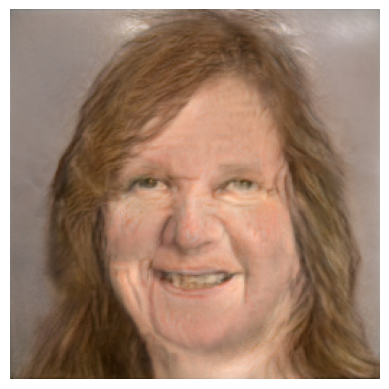

In [43]:
# Replace one style vector with zeros
zero_style_vector = torch.zeros(1, 14, 512).to(device)  # Shape: (1, 14, 512)

# Force CPU-like behavior for synthesis (even on GPU)
with torch.no_grad():  # Disable gradients for inference
    generated_image = gen.synthesis(zero_style_vector, noise_mode='const')  # Generate image

# Check
visualize_image(generated_image)

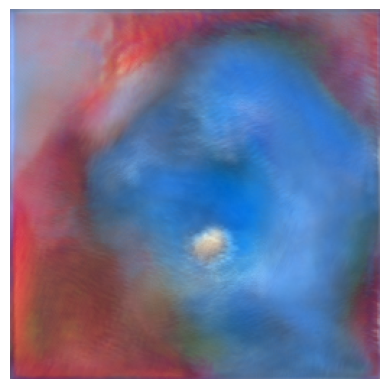

In [44]:
# Debug by replacing style vectors
random_style_vectors = torch.randn(1, 14, 512).to(device)

# Force CPU-like behavior for synthesis (even on GPU)
with torch.no_grad():  # Disable gradients for inference
    generated_image = gen.synthesis(random_style_vectors, noise_mode='const')  # Generate image

visualize_image(generated_image)

Latent Average Shape: torch.Size([14, 512])
Latent Average Mean: 0.12162984162569046
Latent Average Std: 0.2163458615541458


<ipython-input-40-cc064d050dda>:432: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  component.load_state_dict(torch.load(file_path, map_location=torch.device('cuda' if torch.

Loaded rat state from: /content/drive/My Drive/RAFSwap_weights/9/rat_epoch_1000.pth
Loaded transformer_stack state from: /content/drive/My Drive/RAFSwap_weights/9/transformer_stack_epoch_1000.pth
Loaded rap state from: /content/drive/My Drive/RAFSwap_weights/9/rap_epoch_1000.pth
Loaded gap_mlp state from: /content/drive/My Drive/RAFSwap_weights/9/gap_mlp_epoch_1000.pth
Loaded style_vector_extractor state from: /content/drive/My Drive/RAFSwap_weights/9/style_vector_extractor_epoch_1000.pth
Loaded FMP state from: /content/drive/My Drive/RAFSwap_weights/9/FMP_epoch_1000.pth
Mean of style vectors: tensor(0.0219, device='cuda:0')
Std of style vectors: tensor(0.0470, device='cuda:0')
Initializing IDLoss...
Loading ResNet ArcFace


/content/RAFSwap/criteria/id_loss.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.facenet.load_state_dict(torch.load(model_paths['ir_se50']))


IDLoss initialized successfully.
Initializing LPIPS Loss...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


LPIPS Loss initialized successfully.
Initializing W-Norm Loss...
W-Norm Loss initialized successfully.
Loss functions set successfully.


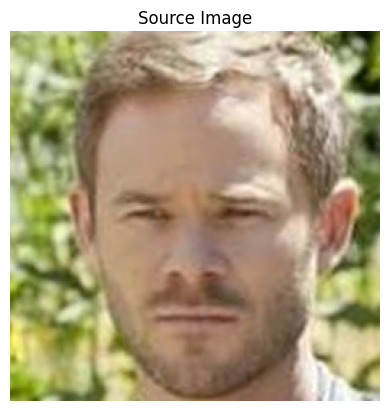

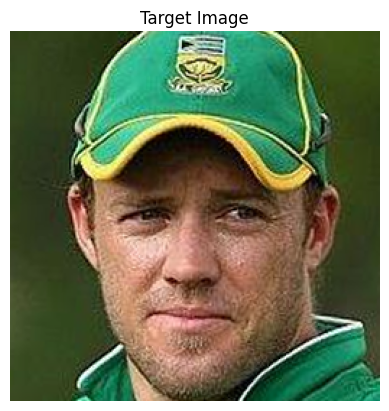

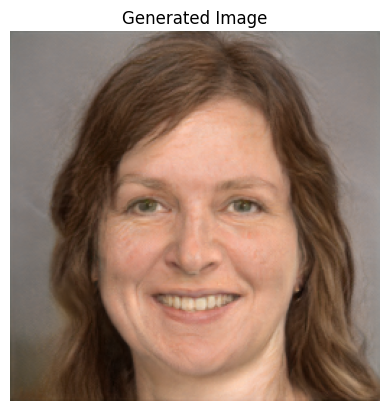

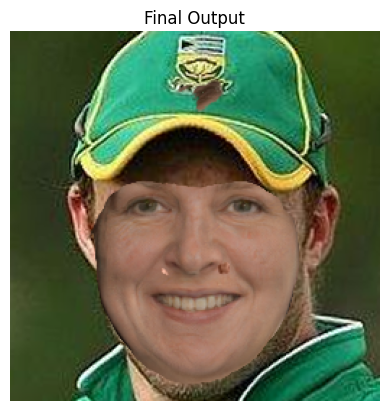

Mask Tensor Shape: torch.Size([1, 1, 256, 256])


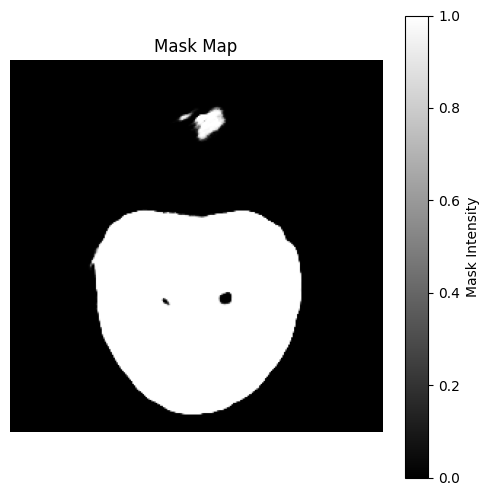

Mean of model.latent_avg: tensor(0.1216, device='cuda:0')
Std of model.latent_avg: tensor(0.2163, device='cuda:0')


In [45]:
# Ensure the device is properly set
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Transformations (optimized for RAFSwap)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),  # Ensure input size matches StyleGAN2
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # StyleGAN normalization
])

# Dataset and DataLoader for RAFSwap with specified folders
source_folder = "/content/drive/MyDrive/VGGFace2_small/n000012"
target_folders = [
    "/content/drive/MyDrive/VGGFace2_small/n000008",
    "/content/drive/MyDrive/VGGFace2_small/n000029",
    "/content/drive/MyDrive/VGGFace2_small/n000052"
]
rafswap_dataset = RAFSwapDataset(
    base_dir="/content/drive/My Drive/VGGFace2_small",
    transform=transform,
    max_pairs=10,
    same_identity_mode=False,
    specify_folders=True,
    source_folder=source_folder,
    target_folders=target_folders
)

# Optimized DataLoader
dataloader = DataLoader(
    rafswap_dataset,
    batch_size=1,  # Adjust batch size based on GPU memory
    shuffle=True,
    num_workers=0,  # Enable parallel data loading
    pin_memory=True  # Speed up data transfer to GPU
)

checkpoint_paths = {
    'stylegan': '/content/drive/MyDrive/aml/stylegan2-ffhq-256x256.pkl',
    'bisenet': '/content/face-parsing.PyTorch/checkpoints/79999_iter.pth'
}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RAFSwap.initialize(checkpoint_paths)

# Directory containing saved files
load_directory = "/content/drive/My Drive/RAFSwap_weights/9"

# Optional suffix for filenames (e.g., loading files from epoch 10)
file_suffix = "epoch_1000"

# Call the load_model_states function
model.load_model_states(load_directory, suffix=file_suffix)

# Set the model to evaluation mode
model.eval()  # <--- Add this here

# Disable gradients for inference
with torch.no_grad():
    source_images, target_images = next(iter(dataloader))
    final_outputs, generated_images, mask_map, style_vectors = model(source_images.to(device), target_images.to(device))

    # Print mean and std of style vectors
    print("Mean of style vectors:", style_vectors.mean())
    print("Std of style vectors:", style_vectors.std())

# Initialize losses
RAFSwap.initialize_losses(model, device)

# Move inputs to the correct device
device = next(model.parameters()).device  # Ensure consistency with model's device
generated_images = generated_images.to(device)
source_images = source_images.to(device)
target_images = target_images.to(device)

model.lambda_id = 0.5
model.lambda_rec = 1
model.lambda_p = 0.8
model.lambda_mask = 1
model.lambda_w_norm = 1
model.lambda_sim = 0.5

# Visualize images
visualize_image(source_images, "Source Image")
visualize_image(target_images, "Target Image")
visualize_image(generated_images, "Generated Image")
visualize_image(final_outputs, "Final Output")

# Visualize mask in gray
visualize_soft_mask(mask_map, "Mask Map")

# Print mean and std of model.latent_avg
print("Mean of model.latent_avg:", model.latent_avg.mean())
print("Std of model.latent_avg:", model.latent_avg.std())

Latent Average Shape: torch.Size([14, 512])
Latent Average Mean: 0.12147054076194763
Latent Average Std: 0.21602678298950195
Loaded rat state from: /content/drive/MyDrive/RAFSwap_weights/9/rat_epoch_1000.pth
Loaded transformer_stack state from: /content/drive/MyDrive/RAFSwap_weights/9/transformer_stack_epoch_1000.pth
Loaded rap state from: /content/drive/MyDrive/RAFSwap_weights/9/rap_epoch_1000.pth
Loaded gap_mlp state from: /content/drive/MyDrive/RAFSwap_weights/9/gap_mlp_epoch_1000.pth


<ipython-input-40-cc064d050dda>:432: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  component.load_state_dict(torch.load(file_path, map_location=torch.device('cuda' if torch.

Loaded style_vector_extractor state from: /content/drive/MyDrive/RAFSwap_weights/9/style_vector_extractor_epoch_1000.pth
Loaded FMP state from: /content/drive/MyDrive/RAFSwap_weights/9/FMP_epoch_1000.pth
Mean of style vectors: tensor(0.0990, device='cuda:0')
Std of style vectors: tensor(0.1777, device='cuda:0')


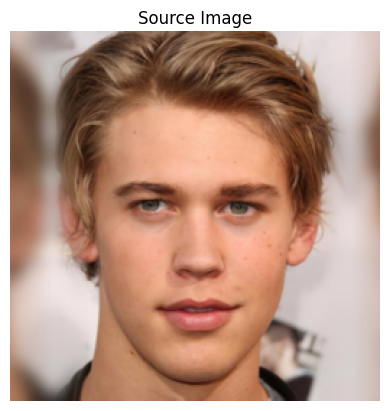

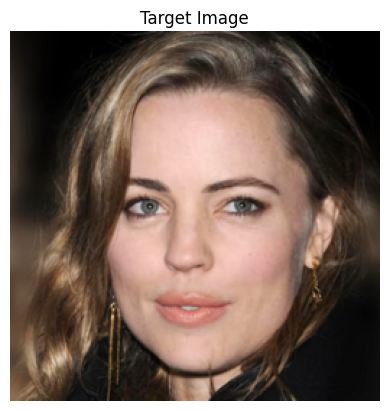

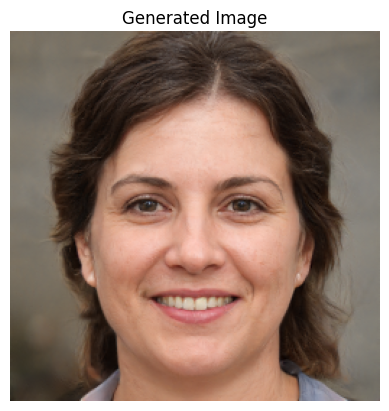

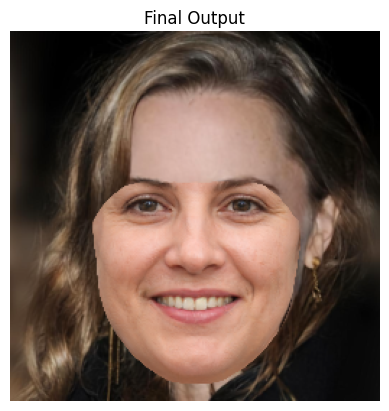

Mask Tensor Shape: torch.Size([1, 1, 256, 256])


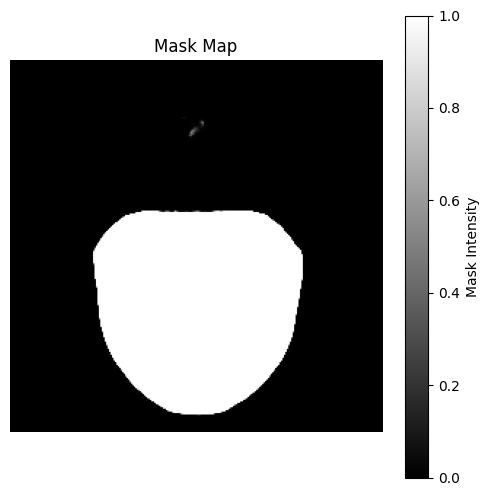

Mean of model.latent_avg: tensor(0.1215, device='cuda:0')
Std of model.latent_avg: tensor(0.2160, device='cuda:0')


In [46]:
from PIL import Image
import torch
from torchvision import transforms

# Ensure the device is properly set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define Transformations (optimized for RAFSwap)
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to match StyleGAN2
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # StyleGAN normalization
])

# Paths for source and target images
source_image_path = "/content/drive/MyDrive/28068.jpg"
target_image_path = "/content/drive/MyDrive/28132.jpg"

# Load images
source_image = Image.open(source_image_path).convert("RGB")
target_image = Image.open(target_image_path).convert("RGB")

# Apply transformations
source_image = transform(source_image).unsqueeze(0).to(device)  # Add batch dimension
target_image = transform(target_image).unsqueeze(0).to(device)

# Initialize model
checkpoint_paths = {
    'stylegan': '/content/drive/MyDrive/aml/stylegan2-ffhq-256x256.pkl',
    'bisenet': '/content/face-parsing.PyTorch/checkpoints/79999_iter.pth'
}
model = RAFSwap.initialize(checkpoint_paths)
model.eval()  # Set the model to evaluation mode

# Load weights
load_directory = "/content/drive/MyDrive/RAFSwap_weights/9"
file_suffix = "epoch_1000"
model.load_model_states(load_directory, suffix=file_suffix)

# Perform inference
with torch.no_grad():
    final_outputs, generated_images, mask_map, style_vectors = model(source_image, target_image)

    # Print mean and std of style vectors
    print("Mean of style vectors:", style_vectors.mean())
    print("Std of style vectors:", style_vectors.std())

# Visualize images
visualize_image(source_image, "Source Image")
visualize_image(target_image, "Target Image")
visualize_image(generated_images, "Generated Image")
visualize_image(final_outputs, "Final Output")

# Visualize mask in gray
visualize_soft_mask(mask_map, "Mask Map")

# Print mean and std of model.latent_avg
print("Mean of model.latent_avg:", model.latent_avg.mean())
print("Std of model.latent_avg:", model.latent_avg.std())

In [47]:
"""
# Calculate loss for output
loss_dict = model.calculate_loss(source_images, target_images, final_outputs, generated_images, mask_map, style_vectors, is_same=False)

# Print losses with 5 decimals
for key, value in loss_dict.items():
    print(f"{key}: {value:.5f}")
    print("")
"""

'\n# Calculate loss for output\nloss_dict = model.calculate_loss(source_images, target_images, final_outputs, generated_images, mask_map, style_vectors, is_same=False)\n\n# Print losses with 5 decimals\nfor key, value in loss_dict.items():\n    print(f"{key}: {value:.5f}")\n    print("")\n'

In [48]:
"""
import json
import matplotlib.pyplot as plt

# Define the path to the loss_logs.json
loss_logs_path = '/content/drive/My Drive/RAFSwap_weights/8/loss_logs.json'

# Load the loss logs
with open(loss_logs_path, 'r') as f:
    loss_logs = json.load(f)

# Extract values for each metric
epochs = [log['epoch'] for log in loss_logs]
metrics = ['total_loss', 'id_loss', 'reconstruction_loss', 'perceptual_loss', 'mask_loss',
           'mask_entropy_loss', 'mask_binary_loss', 'w_norm_loss', 'similarity_improvement_loss']

# Plot each metric in its own graph
for metric in metrics:
    values = [log[metric] for log in loss_logs]
    plt.figure()
    plt.plot(epochs, values, label=metric)
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.title(f'{metric} over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()
"""

"\nimport json\nimport matplotlib.pyplot as plt\n\n# Define the path to the loss_logs.json\nloss_logs_path = '/content/drive/My Drive/RAFSwap_weights/8/loss_logs.json'\n\n# Load the loss logs\nwith open(loss_logs_path, 'r') as f:\n    loss_logs = json.load(f)\n\n# Extract values for each metric\nepochs = [log['epoch'] for log in loss_logs]\nmetrics = ['total_loss', 'id_loss', 'reconstruction_loss', 'perceptual_loss', 'mask_loss',\n           'mask_entropy_loss', 'mask_binary_loss', 'w_norm_loss', 'similarity_improvement_loss']\n\n# Plot each metric in its own graph\nfor metric in metrics:\n    values = [log[metric] for log in loss_logs]\n    plt.figure()\n    plt.plot(epochs, values, label=metric)\n    plt.xlabel('Epoch')\n    plt.ylabel(metric)\n    plt.title(f'{metric} over Epochs')\n    plt.legend()\n    plt.grid(True)\n    plt.show()\n"

## **8. Train**

In [49]:
# Ensure the device is properly set
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Transformations (optimized for RAFSwap)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),  # Ensure input size matches StyleGAN2
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # StyleGAN normalization
])

# Base directory for dataset
base_dir = "/content/drive/My Drive/VGGFace2_small"

# Dataset and DataLoader for RAFSwap with specified folders
source_folder = "/content/drive/MyDrive/VGGFace2_small/n000012"
target_folders = [
    "/content/drive/MyDrive/VGGFace2_small/n000008",
    "/content/drive/MyDrive/VGGFace2_small/n000029",
    "/content/drive/MyDrive/VGGFace2_small/n000052"
]

rafswap_dataset = RAFSwapDataset(
    base_dir=base_dir,
    transform=transform,
    max_pairs=160,
    same_identity_mode=False,
    specify_folders=True,
    source_folder=source_folder,
    target_folders=target_folders
)

# Optimized DataLoader
dataloader = DataLoader(
    rafswap_dataset,
    batch_size=8,  # Adjust batch size based on GPU memory
    shuffle=True,
    num_workers=2,  # Enable parallel data loading
    pin_memory=True  # Speed up data transfer to GPU
)

In [50]:
import numpy as np
import torch

# Path to the precomputed binary mask
binary_mask_path = '/content/drive/MyDrive/average_face_mask.npy'

# Load the precomputed mask
precomputed_mask = np.load(binary_mask_path)

# Initialize model
checkpoint_paths = {
    'stylegan': '/content/drive/MyDrive/aml/stylegan2-ffhq-256x256.pkl',
    'bisenet': '/content/face-parsing.PyTorch/checkpoints/79999_iter.pth'
}
model = RAFSwap.initialize(checkpoint_paths, precomputed_mask=precomputed_mask)

# Set the model to training mode
model.train()


Latent Average Shape: torch.Size([14, 512])
Latent Average Mean: 0.12181932479143143
Latent Average Std: 0.21621504426002502


RAFSwap(
  (encoder): HierarchicalEncoder(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): Re

In [51]:
# Initialize the losses
RAFSwap.initialize_losses(model, device)

Initializing IDLoss...
Loading ResNet ArcFace


/content/RAFSwap/criteria/id_loss.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.facenet.load_state_dict(torch.load(model_paths['ir_se50']))


IDLoss initialized successfully.
Initializing LPIPS Loss...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


LPIPS Loss initialized successfully.
Initializing W-Norm Loss...
W-Norm Loss initialized successfully.
Loss functions set successfully.


In [52]:
save_directory = "/content/drive/My Drive/RAFSwap_weights/9"  # Path to save checkpoints

epochs = 1000         # Total number of epochs
save_interval = 100   # Save model every 5 epochs
reinit_interval = 1  # Reinitialize dataloader every epoch

In [53]:
# Step 7: Start Training
# model.train_model(
    dataset=rafswap_dataset,
    dataloader=dataloader,
    epochs=epochs,
    save_dir=save_directory,
    save_interval=save_interval,
    reinit_interval=reinit_interval,
    lambda_id=0.5,
    lambda_rec=1,
    lambda_p=0.8,
    lambda_mask=5,
    lambda_w_norm=20,
    lambda_sim=0.5
)
print("Training finished!")

IndentationError: unexpected indent (<ipython-input-53-4f2953504158>, line 3)

In [ ]:
import os
import random
import cv2
import numpy as np
import dlib
import matplotlib.pyplot as plt

dd

# Path to landmarks predictor
landmarks_path = "/content/drive/MyDrive/shape_predictor_68_face_landmarks.dat"

# Initialize dlib's face detector and facial landmarks predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(landmarks_path)

# Path to the base directory containing subfolders
base_dir = "/content/drive/MyDrive/VGGFace2_small"

def random_image_from_subfolders(base_dir):
    """
    Randomly selects a folder, then selects a random image from that folder.

    Parameters:
        base_dir (str): Path to the base directory.

    Returns:
        np.array: Loaded image in RGB format.
        str: Path to the selected image.
    """
    # Get list of subfolders
    subfolders = [os.path.join(base_dir, d) for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    if not subfolders:
        raise ValueError(f"No subfolders found in {base_dir}.")

    # Select a random subfolder
    selected_folder = random.choice(subfolders)

    # Get list of images in the selected folder
    images = [os.path.join(selected_folder, f) for f in os.listdir(selected_folder) if f.endswith(('.jpg', '.png'))]
    if not images:
        raise ValueError(f"No images found in {selected_folder}.")

    # Select a random image
    selected_image_path = random.choice(images)

    # Load the image
    image = cv2.imread(selected_image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image_rgb, selected_image_path

def predict_landmarks(image, detector, predictor):
    """
    Predicts facial landmarks using dlib.

    Parameters:
        image (np.array): Input image in RGB format.
        detector (dlib.fhog_object_detector): Dlib face detector.
        predictor (dlib.shape_predictor): Dlib landmark predictor.

    Returns:
        np.array: Landmark coordinates (68, 2) or None if no face is detected.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    faces = detector(gray)
    if len(faces) == 0:
        print("No face detected!")
        return None

    # Process the first detected face
    face = faces[0]
    landmarks = predictor(gray, face)
    return np.array([[p.x, p.y] for p in landmarks.parts()])

# Main loop to process 500 images
num_images = 500
all_landmarks = []

for i in range(num_images):

    if (i + 1) % 100 == 0:
        print(f"Processed {i + 1} images.")

    try:
        # Load a random image
        image, image_path = random_image_from_subfolders(base_dir)
        print(f"Processing image {i + 1}/{num_images}: {image_path}")

        # Align the face
        aligned_face = align_face(image, predictor, detector)

        # Predict landmarks
        landmarks = predict_landmarks(aligned_face, detector, predictor)
        if landmarks is not None:
            all_landmarks.append(landmarks)
        else:
            print("No landmarks detected, skipping image.")
    except Exception as e:
        print(f"Error processing image {i + 1}: {e}")

# Compute average landmarks
if all_landmarks:
    all_landmarks = np.array(all_landmarks)  # Shape: (N, 68, 2)
    average_landmarks = np.mean(all_landmarks, axis=0)  # Shape: (68, 2)

    # Save to a file
    np.save("average_landmarks.npy", average_landmarks)
    print("Average landmarks saved to 'average_landmarks.npy'.")

    # Visualize the average landmarks
    plt.scatter(average_landmarks[:, 0], average_landmarks[:, 1], c='red', s=10)
    plt.title("Average Landmarks")
    plt.gca().invert_yaxis()  # Invert y-axis for proper visualization
    plt.show()
else:
    print("No landmarks detected in any of the images.")

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

dd

image_size = 256  # Assuming 256x256 images
average_landmarks = np.array(average_landmarks, dtype=np.int32)  # Ensure integer format for OpenCV

# Create a blank mask
mask = np.zeros((image_size, image_size), dtype=np.uint8)

# Get the convex hull of the landmarks (outer boundary)
hull = cv2.convexHull(average_landmarks)

# Fill the convex hull area with white (1 in the binary mask)
cv2.fillConvexPoly(mask, hull, 1)

# Verify the mask actually contains the filled convex hull
assert np.any(mask > 0), "Mask creation failed, no convex hull was filled!"

# Save the binary mask to a file
mask_path = '/content/drive/MyDrive/average_face_mask.npy'
np.save(mask_path, mask)
print(f"Binary mask saved to: {mask_path}")

# Visualize the mask
plt.imshow(mask, cmap='gray')
plt.title("Binary Mask")
plt.axis("off")
plt.show()
